## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/cardio/cardio_klek_train.csv")
df_test = pd.read_csv("../../data/train/cardio/cardio_klek_test.csv")
df_valid = pd.read_csv("../../data/train/cardio/cardio_klek_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'pIC50']
y_train_all = df_train_all['pIC50']

X_train = df_train.loc[:, df_train.columns != 'pIC50']
y_train = df_train['pIC50']

X_test = df_test.loc[:, df_test.columns != 'pIC50']
y_test = df_test['pIC50']

X_valid = df_valid.loc[:, df_valid.columns != 'pIC50']
y_valid = df_valid['pIC50']

In [5]:
with open('../../klek_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['cardio']]
X_train = X_train[idxs['cardio']]
X_test = X_test[idxs['cardio']]
X_valid = X_valid[idxs['cardio']]

In [6]:
X_train.shape

(7442, 609)

In [7]:
X_test.shape

(2127, 609)

In [8]:
X_valid.shape

(1063, 609)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [9]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(609, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [10]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [11]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=1063, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 2.937722709813343, Accuracy: -2.7689094543211628
Test Avg. loss: 2.1575329303741455, Accuracy: -1.5349416650829095
################## EPOCH 2 ##################
Train Avg. loss: 2.171692313298647, Accuracy: -1.7408482024727239
Test Avg. loss: 1.6260308027267456, Accuracy: -0.9104660817985533
################## EPOCH 3 ##################
Train Avg. loss: 1.9415713904241636, Accuracy: -1.41811762852438
Test Avg. loss: 1.6178656816482544, Accuracy: -0.9008727360445632
################## EPOCH 4 ##################
Train Avg. loss: 1.876349628483277, Accuracy: -1.3888240615627496
Test Avg. loss: 1.6939491033554077, Accuracy: -0.9902652481243821
################## EPOCH 5 ##################
Train Avg. loss: 1.8349398748045826, Accuracy: -1.2847679459132182
Test Avg. loss: 1.1256107091903687, Accuracy: -0.322509458189685
################## EPOCH 6 ##################
Train Avg. loss: 1.704094962500707

Train Avg. loss: 0.33977742029489877, Accuracy: 0.5789248476928465
Test Avg. loss: 0.339762419462204, Accuracy: 0.6008042340780404
################## EPOCH 48 ##################
Train Avg. loss: 0.3319789418079311, Accuracy: 0.5945357356437052
Test Avg. loss: 0.34201857447624207, Accuracy: 0.5981534526044749
################## EPOCH 49 ##################
Train Avg. loss: 0.33543573211191036, Accuracy: 0.5897497351424368
Test Avg. loss: 0.3341866433620453, Accuracy: 0.6073553630096042
################## EPOCH 50 ##################
Train Avg. loss: 0.3250269516662978, Accuracy: 0.6022962721168109
Test Avg. loss: 0.34183499217033386, Accuracy: 0.5983691269316465
################## EPOCH 51 ##################
Train Avg. loss: 0.3063517221821224, Accuracy: 0.6236077422453717
Test Avg. loss: 0.3414590060710907, Accuracy: 0.5988108980990409
################## EPOCH 52 ##################
Train Avg. loss: 0.3006424136747618, Accuracy: 0.6299721656246515
Test Avg. loss: 0.33292779326438904, Accu

Train Avg. loss: 0.2281406591506475, Accuracy: 0.7264973879782329
Test Avg. loss: 0.34955331683158875, Accuracy: 0.5893006897254398
################## EPOCH 94 ##################
Train Avg. loss: 0.2208660059476615, Accuracy: 0.7349684093373531
Test Avg. loss: 0.3386313021183014, Accuracy: 0.602133220358494
################## EPOCH 95 ##################
Train Avg. loss: 0.21857805188761248, Accuracy: 0.7330821243812359
Test Avg. loss: 0.32747554779052734, Accuracy: 0.6152404066029581
################## EPOCH 96 ##################
Train Avg. loss: 0.21279850036161652, Accuracy: 0.7430178089836171
Test Avg. loss: 0.33076441287994385, Accuracy: 0.6113762338257149
################## EPOCH 97 ##################
Train Avg. loss: 0.21489879623247318, Accuracy: 0.7433415160083946
Test Avg. loss: 0.33237576484680176, Accuracy: 0.6094830438892711
################## EPOCH 98 ##################
Train Avg. loss: 0.2143866951565374, Accuracy: 0.7397482306320816
Test Avg. loss: 0.3427543640136719, Ac

Train Avg. loss: 0.18186280670148108, Accuracy: 0.7817538722694326
Test Avg. loss: 0.31977397203445435, Accuracy: 0.6242891986419645
################## EPOCH 140 ##################
Train Avg. loss: 0.18186650519527078, Accuracy: 0.7783802513527034
Test Avg. loss: 0.3315644860267639, Accuracy: 0.6104362077351575
################## EPOCH 141 ##################
Train Avg. loss: 0.1839524833525455, Accuracy: 0.7748526295288442
Test Avg. loss: 0.32481086254119873, Accuracy: 0.6183712186232342
################## EPOCH 142 ##################
Train Avg. loss: 0.18121039056790744, Accuracy: 0.780074371803468
Test Avg. loss: 0.31836140155792236, Accuracy: 0.6259488584165744
################## EPOCH 143 ##################
Train Avg. loss: 0.18370706604018233, Accuracy: 0.7785986214228631
Test Avg. loss: 0.3284798860549927, Accuracy: 0.614060366113937
################## EPOCH 144 ##################
Train Avg. loss: 0.18709015710351293, Accuracy: 0.7758735787940381
Test Avg. loss: 0.323981642723083

Train Avg. loss: 0.16376315076463724, Accuracy: 0.8023421150036388
Test Avg. loss: 0.3161923289299011, Accuracy: 0.6284973467843575
################## EPOCH 186 ##################
Train Avg. loss: 0.16087817341536922, Accuracy: 0.804576388548256
Test Avg. loss: 0.32482704520225525, Accuracy: 0.6183521823346096
################## EPOCH 187 ##################
Train Avg. loss: 0.1703058409268764, Accuracy: 0.7976665015665155
Test Avg. loss: 0.3267252743244171, Accuracy: 0.6161219499929461
################## EPOCH 188 ##################
Train Avg. loss: 0.16012204603128166, Accuracy: 0.8076581412333192
Test Avg. loss: 0.3253045082092285, Accuracy: 0.6177912248049148
################## EPOCH 189 ##################
Train Avg. loss: 0.17351948330778422, Accuracy: 0.7913951634916565
Test Avg. loss: 0.3294585645198822, Accuracy: 0.6129105134686266
################## EPOCH 190 ##################
Train Avg. loss: 0.16079659801568086, Accuracy: 0.8074297084872499
Test Avg. loss: 0.3251642882823944

Train Avg. loss: 0.15924442193346985, Accuracy: 0.8104125799582025
Test Avg. loss: 0.3109453022480011, Accuracy: 0.6346622660698492
################## EPOCH 232 ##################
Train Avg. loss: 0.1476028081781107, Accuracy: 0.8241296500650249
Test Avg. loss: 0.3161256015300751, Accuracy: 0.6285757805444028
################## EPOCH 233 ##################
Train Avg. loss: 0.15050305817835832, Accuracy: 0.8206877306445876
Test Avg. loss: 0.31858307123184204, Accuracy: 0.6256884006877772
################## EPOCH 234 ##################
Train Avg. loss: 0.15657416663968, Accuracy: 0.8128321820728203
Test Avg. loss: 0.322459876537323, Accuracy: 0.6211334725734279
################## EPOCH 235 ##################
Train Avg. loss: 0.1507107633377861, Accuracy: 0.8196210049097706
Test Avg. loss: 0.3165992796421051, Accuracy: 0.6280192105164395
################## EPOCH 236 ##################
Train Avg. loss: 0.1460522230346827, Accuracy: 0.8231875554632423
Test Avg. loss: 0.31991612911224365, Ac

Train Avg. loss: 0.14470780180375464, Accuracy: 0.8267496488412349
Test Avg. loss: 0.32368388772010803, Accuracy: 0.6196952927595623
################## EPOCH 278 ##################
Train Avg. loss: 0.15089730985558597, Accuracy: 0.8192353114339499
Test Avg. loss: 0.32507243752479553, Accuracy: 0.6180638692312859
################## EPOCH 279 ##################
Train Avg. loss: 0.14787199340217103, Accuracy: 0.8237170806282722
Test Avg. loss: 0.32474595308303833, Accuracy: 0.6184474895004402
################## EPOCH 280 ##################
Train Avg. loss: 0.1429906010212049, Accuracy: 0.8278831342922405
Test Avg. loss: 0.3189666271209717, Accuracy: 0.6252377494094079
################## EPOCH 281 ##################
Train Avg. loss: 0.1380582106151806, Accuracy: 0.8357306694133576
Test Avg. loss: 0.3174474835395813, Accuracy: 0.62702264003211
################## EPOCH 282 ##################
Train Avg. loss: 0.14928776428679028, Accuracy: 0.8206647513391493
Test Avg. loss: 0.3225191235542297

Train Avg. loss: 1.2929613534201922, Accuracy: -0.5116036366796249
Test Avg. loss: 0.597077488899231, Accuracy: 0.29847800488168763
################## EPOCH 24 ##################
Train Avg. loss: 1.267664632226667, Accuracy: -0.4881664328653425
Test Avg. loss: 0.5985766649246216, Accuracy: 0.2967165987520036
################## EPOCH 25 ##################
Train Avg. loss: 1.2332077209766095, Accuracy: -0.4313111890202423
Test Avg. loss: 0.6228618025779724, Accuracy: 0.2681833364461772
################## EPOCH 26 ##################
Train Avg. loss: 1.2444862473724234, Accuracy: -0.45855724702837336
Test Avg. loss: 0.9259313344955444, Accuracy: -0.08790089643195809
################## EPOCH 27 ##################
Train Avg. loss: 1.1728120420733068, Accuracy: -0.35653864239787897
Test Avg. loss: 0.6638052463531494, Accuracy: 0.22007778661264465
################## EPOCH 28 ##################
Train Avg. loss: 1.0874252910287971, Accuracy: -0.27486341806085474
Test Avg. loss: 0.531555235385894

Train Avg. loss: 0.3368145488520973, Accuracy: 0.6159485068184783
Test Avg. loss: 0.33277034759521484, Accuracy: 0.6090194112857675
################## EPOCH 70 ##################
Train Avg. loss: 0.33456374322756743, Accuracy: 0.6137020293164783
Test Avg. loss: 0.34146830439567566, Accuracy: 0.5987999537314999
################## EPOCH 71 ##################
Train Avg. loss: 0.3355839733894055, Accuracy: 0.6126080590796745
Test Avg. loss: 0.33669328689575195, Accuracy: 0.6044102305881531
################## EPOCH 72 ##################
Train Avg. loss: 0.3227110223637687, Accuracy: 0.6312089753340064
Test Avg. loss: 0.3374082148075104, Accuracy: 0.6035702375606489
################## EPOCH 73 ##################
Train Avg. loss: 0.32624225853345334, Accuracy: 0.6244458128057017
Test Avg. loss: 0.3419376015663147, Accuracy: 0.5982485410551432
################## EPOCH 74 ##################
Train Avg. loss: 0.31233793548029715, Accuracy: 0.6411465668927087
Test Avg. loss: 0.34409937262535095, A

Train Avg. loss: 0.21093025708045715, Accuracy: 0.759053641465281
Test Avg. loss: 0.3141632080078125, Accuracy: 0.6308814095793791
################## EPOCH 116 ##################
Train Avg. loss: 0.2092699028360538, Accuracy: 0.7604869499295595
Test Avg. loss: 0.32426899671554565, Accuracy: 0.6190078438290512
################## EPOCH 117 ##################
Train Avg. loss: 0.2146267765480229, Accuracy: 0.7534297568065209
Test Avg. loss: 0.3204862177371979, Accuracy: 0.6234523661188156
################## EPOCH 118 ##################
Train Avg. loss: 0.20979075999850902, Accuracy: 0.7568276683156016
Test Avg. loss: 0.3182554244995117, Accuracy: 0.6260733765728751
################## EPOCH 119 ##################
Train Avg. loss: 0.20652231812859193, Accuracy: 0.7639106348690037
Test Avg. loss: 0.3285386860370636, Accuracy: 0.6139912924452731
################## EPOCH 120 ##################
Train Avg. loss: 0.2035952514817572, Accuracy: 0.7653918150771596
Test Avg. loss: 0.3288111090660095, 

Train Avg. loss: 0.18367435152714068, Accuracy: 0.7898957383052236
Test Avg. loss: 0.31284886598587036, Accuracy: 0.6324256569594937
################## EPOCH 162 ##################
Train Avg. loss: 0.1879209814927517, Accuracy: 0.7866554621294829
Test Avg. loss: 0.32165226340293884, Accuracy: 0.6220823383788705
################## EPOCH 163 ##################
Train Avg. loss: 0.18502329480953705, Accuracy: 0.7875845512159589
Test Avg. loss: 0.32674747705459595, Accuracy: 0.6160958282282172
################## EPOCH 164 ##################
Train Avg. loss: 0.18350153400475144, Accuracy: 0.7932570655140447
Test Avg. loss: 0.3268788456916809, Accuracy: 0.6159415007956726
################## EPOCH 165 ##################
Train Avg. loss: 0.17525152295318425, Accuracy: 0.797733015569466
Test Avg. loss: 0.3202320635318756, Accuracy: 0.6237509509907928
################## EPOCH 166 ##################
Train Avg. loss: 0.17899101014193305, Accuracy: 0.7953735829640843
Test Avg. loss: 0.31432697176933

Train Avg. loss: 0.16614726020230186, Accuracy: 0.8085091779408001
Test Avg. loss: 0.3233443796634674, Accuracy: 0.6200942078970506
################## EPOCH 208 ##################
Train Avg. loss: 0.16412190058165127, Accuracy: 0.8137809084651829
Test Avg. loss: 0.32027021050453186, Accuracy: 0.6237061542247646
################## EPOCH 209 ##################
Train Avg. loss: 0.16871741948983607, Accuracy: 0.8063817881559299
Test Avg. loss: 0.32476967573165894, Accuracy: 0.6184196222790808
################## EPOCH 210 ##################
Train Avg. loss: 0.16334114109094328, Accuracy: 0.8154990776840957
Test Avg. loss: 0.3150329887866974, Accuracy: 0.629859499868796
################## EPOCH 211 ##################
Train Avg. loss: 0.16003259166310996, Accuracy: 0.8174628249108755
Test Avg. loss: 0.31971585750579834, Accuracy: 0.6243574583139107
################## EPOCH 212 ##################
Train Avg. loss: 0.14969538171321917, Accuracy: 0.8289469545643988
Test Avg. loss: 0.3249765038490

Train Avg. loss: 0.15615565699135137, Accuracy: 0.8214460793264475
Test Avg. loss: 0.3213583528995514, Accuracy: 0.6224276879150985
################## EPOCH 254 ##################
Train Avg. loss: 0.15916418484770334, Accuracy: 0.8191883648034113
Test Avg. loss: 0.3244512677192688, Accuracy: 0.6187937239555442
################## EPOCH 255 ##################
Train Avg. loss: 0.14927111365474188, Accuracy: 0.830249525005306
Test Avg. loss: 0.33919036388397217, Accuracy: 0.6014763587709525
################## EPOCH 256 ##################
Train Avg. loss: 0.1497675142227075, Accuracy: 0.8288711740364945
Test Avg. loss: 0.3252616822719574, Accuracy: 0.6178415617148467
################## EPOCH 257 ##################
Train Avg. loss: 0.1442710383452921, Accuracy: 0.8349897945300254
Test Avg. loss: 0.3164020776748657, Accuracy: 0.6282509344487032
################## EPOCH 258 ##################
Train Avg. loss: 0.15420557326103887, Accuracy: 0.8236956680520682
Test Avg. loss: 0.3215652406215668,

Train Avg. loss: 0.14239435528333372, Accuracy: 0.8370939451234328
Test Avg. loss: 0.3271576762199402, Accuracy: 0.6156138663807902
################## EPOCH 300 ##################
Train Avg. loss: 0.14751414890982148, Accuracy: 0.8318317870674149
Test Avg. loss: 0.32694748044013977, Accuracy: 0.6158608711696453
Model: lr 0.001, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 4.202762799747919, Accuracy: -3.8484571636044795
Test Avg. loss: 3.5466439723968506, Accuracy: -3.1670447533054675
################## EPOCH 2 ##################
Train Avg. loss: 1.9360089160628238, Accuracy: -1.233667381302892
Test Avg. loss: 2.7397549152374268, Accuracy: -2.219009335149425
################## EPOCH 3 ##################
Train Avg. loss: 1.8801079806634935, Accuracy: -1.1818017365269624
Test Avg. loss: 2.801828145980835, Accuracy: -2.2919411922620037
################## EPOCH 4 ##################
Train Avg. loss: 1.8591834609791384, Accuracy: -1.1395941481180805
Test Avg.

Train Avg. loss: 0.9420358174938267, Accuracy: -0.09066805440479571
Test Avg. loss: 0.5865843892097473, Accuracy: 0.310806641141232
################## EPOCH 46 ##################
Train Avg. loss: 0.9561013831930646, Accuracy: -0.10065092743289414
Test Avg. loss: 0.6848297715187073, Accuracy: 0.19537556951148471
################## EPOCH 47 ##################
Train Avg. loss: 0.9440755945141033, Accuracy: -0.0655933183958201
Test Avg. loss: 0.7981413006782532, Accuracy: 0.06224290233722318
################## EPOCH 48 ##################
Train Avg. loss: 0.9040931736008596, Accuracy: -0.05142851107883831
Test Avg. loss: 0.6165934205055237, Accuracy: 0.2755481468343365
################## EPOCH 49 ##################
Train Avg. loss: 0.9085493118076001, Accuracy: -0.04054585957973125
Test Avg. loss: 0.6981320381164551, Accuracy: 0.17974640723018687
################## EPOCH 50 ##################
Train Avg. loss: 0.8941491508887986, Accuracy: -0.028577460933992997
Test Avg. loss: 0.683223605155

Train Avg. loss: 0.45776571712251435, Accuracy: 0.47748257356765184
Test Avg. loss: 0.3762979805469513, Accuracy: 0.5578776240081362
################## EPOCH 92 ##################
Train Avg. loss: 0.4570906619399281, Accuracy: 0.482919001447911
Test Avg. loss: 0.3701344132423401, Accuracy: 0.5651193834073589
################## EPOCH 93 ##################
Train Avg. loss: 0.44410568324186034, Accuracy: 0.4812539897610802
Test Avg. loss: 0.3805994987487793, Accuracy: 0.5528236565612867
################## EPOCH 94 ##################
Train Avg. loss: 0.43054033234968025, Accuracy: 0.5117423932476622
Test Avg. loss: 0.3690303862094879, Accuracy: 0.5664165332641138
################## EPOCH 95 ##################
Train Avg. loss: 0.42376752829147596, Accuracy: 0.5173953586154929
Test Avg. loss: 0.3702366352081299, Accuracy: 0.5649992885176386
################## EPOCH 96 ##################
Train Avg. loss: 0.43964564471931783, Accuracy: 0.5028200994626866
Test Avg. loss: 0.3508279621601105, Acc

Train Avg. loss: 0.24614781823198675, Accuracy: 0.722002401085454
Test Avg. loss: 0.3278655707836151, Accuracy: 0.6147821393470077
################## EPOCH 138 ##################
Train Avg. loss: 0.2527919217186459, Accuracy: 0.711005339528754
Test Avg. loss: 0.3274652659893036, Accuracy: 0.6152525053514091
################## EPOCH 139 ##################
Train Avg. loss: 0.24141680335594437, Accuracy: 0.7260974006943723
Test Avg. loss: 0.3238998353481293, Accuracy: 0.6194415826995939
################## EPOCH 140 ##################
Train Avg. loss: 0.2448901261313487, Accuracy: 0.7197851831870512
Test Avg. loss: 0.331314355134964, Accuracy: 0.6107301021010731
################## EPOCH 141 ##################
Train Avg. loss: 0.24012824817229125, Accuracy: 0.7303864892840543
Test Avg. loss: 0.3331320881843567, Accuracy: 0.6085943882462771
################## EPOCH 142 ##################
Train Avg. loss: 0.2287873350462671, Accuracy: 0.7380107131022395
Test Avg. loss: 0.3308437764644623, Acc

Train Avg. loss: 0.19866521580744598, Accuracy: 0.7751198220054087
Test Avg. loss: 0.32266664505004883, Accuracy: 0.6208904792669669
################## EPOCH 184 ##################
Train Avg. loss: 0.19919667279316208, Accuracy: 0.7762526673968873
Test Avg. loss: 0.3213919997215271, Accuracy: 0.6223881318573463
################## EPOCH 185 ##################
Train Avg. loss: 0.1916572131469088, Accuracy: 0.7855667085204012
Test Avg. loss: 0.32253357768058777, Accuracy: 0.6210468384543597
################## EPOCH 186 ##################
Train Avg. loss: 0.19554172696198446, Accuracy: 0.7780316553894955
Test Avg. loss: 0.3445916771888733, Accuracy: 0.595130229206499
################## EPOCH 187 ##################
Train Avg. loss: 0.19552746554047373, Accuracy: 0.7799681560586864
Test Avg. loss: 0.3358056843280792, Accuracy: 0.6054530908677958
################## EPOCH 188 ##################
Train Avg. loss: 0.18919266286795422, Accuracy: 0.788818647577211
Test Avg. loss: 0.336575984954834,

Train Avg. loss: 0.17318841221473985, Accuracy: 0.8046397945747831
Test Avg. loss: 0.3280949592590332, Accuracy: 0.6145126422358924
################## EPOCH 230 ##################
Train Avg. loss: 0.17564483706728887, Accuracy: 0.80297497258958
Test Avg. loss: 0.3161001205444336, Accuracy: 0.6286057111719026
################## EPOCH 231 ##################
Train Avg. loss: 0.1805408417042029, Accuracy: 0.7970533089390381
Test Avg. loss: 0.32428160309791565, Accuracy: 0.6189930602461677
################## EPOCH 232 ##################
Train Avg. loss: 0.17800633962881768, Accuracy: 0.8007806247745867
Test Avg. loss: 0.32534608244895935, Accuracy: 0.6177423530645371
################## EPOCH 233 ##################
Train Avg. loss: 0.17012610052854327, Accuracy: 0.8106845835540982
Test Avg. loss: 0.3275861442089081, Accuracy: 0.615110472956643
################## EPOCH 234 ##################
Train Avg. loss: 0.17631237524545798, Accuracy: 0.7965666482291233
Test Avg. loss: 0.33545374870300293

Train Avg. loss: 0.18201208341929873, Accuracy: 0.7979550000144724
Test Avg. loss: 0.33211421966552734, Accuracy: 0.6097903338819335
################## EPOCH 276 ##################
Train Avg. loss: 0.16378799775394343, Accuracy: 0.8176490133357992
Test Avg. loss: 0.3275429308414459, Accuracy: 0.6151612201263517
################## EPOCH 277 ##################
Train Avg. loss: 0.17181333198638285, Accuracy: 0.8082144658963091
Test Avg. loss: 0.3203529715538025, Accuracy: 0.6236089177454223
################## EPOCH 278 ##################
Train Avg. loss: 0.162832440019159, Accuracy: 0.820280029167061
Test Avg. loss: 0.32204556465148926, Accuracy: 0.6216202478765174
################## EPOCH 279 ##################
Train Avg. loss: 0.16272224706865973, Accuracy: 0.8177804586797104
Test Avg. loss: 0.3230755031108856, Accuracy: 0.6204101517569987
################## EPOCH 280 ##################
Train Avg. loss: 0.1736984110863532, Accuracy: 0.8057874352752593
Test Avg. loss: 0.3217526972293854,

Train Avg. loss: 1.5263211607933045, Accuracy: -0.7635763360861144
Test Avg. loss: 1.4226388931274414, Accuracy: -0.6714956172196513
################## EPOCH 22 ##################
Train Avg. loss: 1.4451478123664856, Accuracy: -0.652288234142129
Test Avg. loss: 1.4000917673110962, Accuracy: -0.6450044992794131
################## EPOCH 23 ##################
Train Avg. loss: 1.4523431440194448, Accuracy: -0.6910913827937016
Test Avg. loss: 1.223480224609375, Accuracy: -0.43749889682496046
################## EPOCH 24 ##################
Train Avg. loss: 1.4320547531048458, Accuracy: -0.6248531097475929
Test Avg. loss: 1.3513667583465576, Accuracy: -0.5877563213481836
################## EPOCH 25 ##################
Train Avg. loss: 1.4239340782165528, Accuracy: -0.6734831892551507
Test Avg. loss: 1.379728078842163, Accuracy: -0.6210787661473254
################## EPOCH 26 ##################
Train Avg. loss: 1.481876277923584, Accuracy: -0.8228169531765394
Test Avg. loss: 1.274087905883789, A

Train Avg. loss: 1.0306811412175496, Accuracy: -0.2109480514930399
Test Avg. loss: 0.7490981817245483, Accuracy: 0.11986486967569143
################## EPOCH 68 ##################
Train Avg. loss: 1.0117354412873587, Accuracy: -0.2004506620380062
Test Avg. loss: 0.6122568845748901, Accuracy: 0.2806432818079264
################## EPOCH 69 ##################
Train Avg. loss: 0.9817514002323151, Accuracy: -0.15216637265692073
Test Avg. loss: 0.6222413778305054, Accuracy: 0.26891232870820425
################## EPOCH 70 ##################
Train Avg. loss: 0.9601926227410634, Accuracy: -0.1714446600898525
Test Avg. loss: 0.6197702884674072, Accuracy: 0.2718156596178878
################## EPOCH 71 ##################
Train Avg. loss: 0.9840486605962118, Accuracy: -0.15909379141019178
Test Avg. loss: 0.5494227409362793, Accuracy: 0.35446879768728057
################## EPOCH 72 ##################
Train Avg. loss: 0.9424084613720576, Accuracy: -0.08250451814193925
Test Avg. loss: 0.58322000503540

Train Avg. loss: 0.6640621602535248, Accuracy: 0.2053876197392407
Test Avg. loss: 0.43433496356010437, Accuracy: 0.48968849253034996
################## EPOCH 114 ##################
Train Avg. loss: 0.6751838564872742, Accuracy: 0.19507727463706712
Test Avg. loss: 0.5272190570831299, Accuracy: 0.380556588179911
################## EPOCH 115 ##################
Train Avg. loss: 0.6624738534291585, Accuracy: 0.1968253588537317
Test Avg. loss: 0.4591522514820099, Accuracy: 0.46052998462269135
################## EPOCH 116 ##################
Train Avg. loss: 0.6571426173051198, Accuracy: 0.24893539440798035
Test Avg. loss: 0.43001827597618103, Accuracy: 0.49476027448250726
################## EPOCH 117 ##################
Train Avg. loss: 0.6512921114762624, Accuracy: 0.21718232257062572
Test Avg. loss: 0.4501967430114746, Accuracy: 0.4710520449596316
################## EPOCH 118 ##################
Train Avg. loss: 0.6395102600256602, Accuracy: 0.24322427343872555
Test Avg. loss: 0.4570528268814

Train Avg. loss: 0.46067269941171013, Accuracy: 0.45250732894113427
Test Avg. loss: 0.35740211606025696, Accuracy: 0.5800788879995269
################## EPOCH 160 ##################
Train Avg. loss: 0.4339273413022359, Accuracy: 0.4917080787708985
Test Avg. loss: 0.357001930475235, Accuracy: 0.5805491091488797
################## EPOCH 161 ##################
Train Avg. loss: 0.4202060600121816, Accuracy: 0.5227916918719463
Test Avg. loss: 0.3703019320964813, Accuracy: 0.5649225631526575
################## EPOCH 162 ##################
Train Avg. loss: 0.4197324236234029, Accuracy: 0.5146898463402001
Test Avg. loss: 0.35266226530075073, Accuracy: 0.5856478749006475
################## EPOCH 163 ##################
Train Avg. loss: 0.4290467083454132, Accuracy: 0.49982480486743347
Test Avg. loss: 0.36009418964385986, Accuracy: 0.5769159220024707
################## EPOCH 164 ##################
Train Avg. loss: 0.4181471859415372, Accuracy: 0.5237235056499007
Test Avg. loss: 0.3608208298683166

Train Avg. loss: 0.3053621783852577, Accuracy: 0.6471098461198413
Test Avg. loss: 0.3508822023868561, Accuracy: 0.5877393260430976
################## EPOCH 206 ##################
Train Avg. loss: 0.27983385423819224, Accuracy: 0.6766670479115923
Test Avg. loss: 0.3442005515098572, Accuracy: 0.5955897563437822
################## EPOCH 207 ##################
Train Avg. loss: 0.27886096214254696, Accuracy: 0.6830982553430018
Test Avg. loss: 0.3514818251132965, Accuracy: 0.5870348054641049
################## EPOCH 208 ##################
Train Avg. loss: 0.2837947775920232, Accuracy: 0.6794714384945253
Test Avg. loss: 0.34836432337760925, Accuracy: 0.5906976483753856
################## EPOCH 209 ##################
Train Avg. loss: 0.2877931982278824, Accuracy: 0.6633309991898121
Test Avg. loss: 0.3361664414405823, Accuracy: 0.6050292368674642
################## EPOCH 210 ##################
Train Avg. loss: 0.28117547929286957, Accuracy: 0.6760893502076794
Test Avg. loss: 0.3530607521533966,

Train Avg. loss: 0.2111627648274104, Accuracy: 0.7564121172526196
Test Avg. loss: 0.3464336693286896, Accuracy: 0.5929660165816029
################## EPOCH 252 ##################
Train Avg. loss: 0.21081379875540734, Accuracy: 0.7585036805751298
Test Avg. loss: 0.34427738189697266, Accuracy: 0.5954994825643253
################## EPOCH 253 ##################
Train Avg. loss: 0.21283420361578465, Accuracy: 0.7616838747042212
Test Avg. loss: 0.36276575922966003, Accuracy: 0.573777042749996
################## EPOCH 254 ##################
Train Avg. loss: 0.21765490757922332, Accuracy: 0.7547236704757989
Test Avg. loss: 0.34907010197639465, Accuracy: 0.5898684126887612
################## EPOCH 255 ##################
Train Avg. loss: 0.2079505739112695, Accuracy: 0.7631998929323438
Test Avg. loss: 0.353289395570755, Accuracy: 0.5849110086436347
################## EPOCH 256 ##################
Train Avg. loss: 0.21317503452301026, Accuracy: 0.7565054592421152
Test Avg. loss: 0.3270305991172790

Train Avg. loss: 0.17564154093464215, Accuracy: 0.7981032074190938
Test Avg. loss: 0.33631160855293274, Accuracy: 0.6048586956424579
################## EPOCH 298 ##################
Train Avg. loss: 0.17937481390933196, Accuracy: 0.7983252953239038
Test Avg. loss: 0.33468323945999146, Accuracy: 0.6067718826345385
################## EPOCH 299 ##################
Train Avg. loss: 0.16932433918118478, Accuracy: 0.802274969417422
Test Avg. loss: 0.3457777500152588, Accuracy: 0.5937366675629714
################## EPOCH 300 ##################
Train Avg. loss: 0.1716729335486889, Accuracy: 0.8069208575782684
Test Avg. loss: 0.3272121250629425, Accuracy: 0.615549921144088
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 3.4590926395465376, Accuracy: -3.2535988834863905
Test Avg. loss: 1.542898416519165, Accuracy: -0.8127917808108494
################## EPOCH 2 ##################
Train Avg. loss: 2.1935606834202876, Accuracy: -1.7703088383165566
Test Av

Train Avg. loss: 0.3860674354331688, Accuracy: 0.5460960038301638
Test Avg. loss: 0.3773822486400604, Accuracy: 0.5566037009131222
################## EPOCH 44 ##################
Train Avg. loss: 0.3764511886584401, Accuracy: 0.5480471481196303
Test Avg. loss: 0.3892979323863983, Accuracy: 0.5426036642613222
################## EPOCH 45 ##################
Train Avg. loss: 0.3549683072920009, Accuracy: 0.5705317392529261
Test Avg. loss: 0.3694334030151367, Accuracy: 0.565943034403792
################## EPOCH 46 ##################
Train Avg. loss: 0.3789130717579899, Accuracy: 0.5523139083186662
Test Avg. loss: 0.3666040599346161, Accuracy: 0.5692673059091845
################## EPOCH 47 ##################
Train Avg. loss: 0.37341573933547145, Accuracy: 0.5543737852486199
Test Avg. loss: 0.37425458431243896, Accuracy: 0.5602784912987804
################## EPOCH 48 ##################
Train Avg. loss: 0.3601794707161163, Accuracy: 0.5720260082737967
Test Avg. loss: 0.3969281017780304, Accurac

Train Avg. loss: 0.3007060542318954, Accuracy: 0.6370918649865132
Test Avg. loss: 0.4045619070529938, Accuracy: 0.5246695964483559
################## EPOCH 90 ##################
Train Avg. loss: 0.2910901497681765, Accuracy: 0.6545245979796026
Test Avg. loss: 0.3621555268764496, Accuracy: 0.5744940330337274
################## EPOCH 91 ##################
Train Avg. loss: 0.2981603552663275, Accuracy: 0.6494116878015148
Test Avg. loss: 0.34588858485221863, Accuracy: 0.593606438718757
################## EPOCH 92 ##################
Train Avg. loss: 0.31023833763190095, Accuracy: 0.6337418732904406
Test Avg. loss: 0.3654569685459137, Accuracy: 0.5706150377676271
################## EPOCH 93 ##################
Train Avg. loss: 0.2959903854029373, Accuracy: 0.6484657821533836
Test Avg. loss: 0.35501790046691895, Accuracy: 0.5828801389236402
################## EPOCH 94 ##################
Train Avg. loss: 0.2916851328613932, Accuracy: 0.6488818061849803
Test Avg. loss: 0.3571946918964386, Accura

Train Avg. loss: 0.27166814459367883, Accuracy: 0.6803981221969456
Test Avg. loss: 0.3485189974308014, Accuracy: 0.5905159140363622
################## EPOCH 136 ##################
Train Avg. loss: 0.2559489424904017, Accuracy: 0.6950412513497323
Test Avg. loss: 0.3531600534915924, Accuracy: 0.5850629900206191
################## EPOCH 137 ##################
Train Avg. loss: 0.26275498567093086, Accuracy: 0.6899049811968869
Test Avg. loss: 0.3479458689689636, Accuracy: 0.5911892774204935
################## EPOCH 138 ##################
Train Avg. loss: 0.27067549417970516, Accuracy: 0.683477431083045
Test Avg. loss: 0.33425334095954895, Accuracy: 0.6072769664950661
################## EPOCH 139 ##################
Train Avg. loss: 0.2670017202332808, Accuracy: 0.6809886432270718
Test Avg. loss: 0.3390498459339142, Accuracy: 0.6016414369266179
################## EPOCH 140 ##################
Train Avg. loss: 0.2581687307408951, Accuracy: 0.6921936141837017
Test Avg. loss: 0.34502309560775757,

Train Avg. loss: 0.23650935493697425, Accuracy: 0.7179455466620549
Test Avg. loss: 0.36848124861717224, Accuracy: 0.5670617447154815
################## EPOCH 182 ##################
Train Avg. loss: 0.24877252282630732, Accuracy: 0.7073177318628188
Test Avg. loss: 0.35907912254333496, Accuracy: 0.5781085419453599
################## EPOCH 183 ##################
Train Avg. loss: 0.2443613757902972, Accuracy: 0.7144434498722627
Test Avg. loss: 0.3475327789783478, Accuracy: 0.5916746484467383
################## EPOCH 184 ##################
Train Avg. loss: 0.23525387723430544, Accuracy: 0.7210599881157657
Test Avg. loss: 0.35187456011772156, Accuracy: 0.5865733819435892
################## EPOCH 185 ##################
Train Avg. loss: 0.24112280704432804, Accuracy: 0.7176796054694775
Test Avg. loss: 0.3457210659980774, Accuracy: 0.5938032694633109
################## EPOCH 186 ##################
Train Avg. loss: 0.24007555433097316, Accuracy: 0.7139867619848123
Test Avg. loss: 0.3553518056869

Train Avg. loss: 0.235396469451583, Accuracy: 0.7259513586517392
Test Avg. loss: 0.33884450793266296, Accuracy: 0.601882704941921
################## EPOCH 228 ##################
Train Avg. loss: 0.22561204372685353, Accuracy: 0.7326559982149633
Test Avg. loss: 0.3497447669506073, Accuracy: 0.5890757317023091
################## EPOCH 229 ##################
Train Avg. loss: 0.22269037158064575, Accuracy: 0.7373113645615772
Test Avg. loss: 0.358867883682251, Accuracy: 0.5783567254654243
################## EPOCH 230 ##################
Train Avg. loss: 0.22832179657891072, Accuracy: 0.7312673908069444
Test Avg. loss: 0.34394046664237976, Accuracy: 0.5958953557726991
################## EPOCH 231 ##################
Train Avg. loss: 0.22866701456226504, Accuracy: 0.7300846116630296
Test Avg. loss: 0.34216347336769104, Accuracy: 0.5979831534265532
################## EPOCH 232 ##################
Train Avg. loss: 0.22366775933637129, Accuracy: 0.737168164048767
Test Avg. loss: 0.35090872645378113

Train Avg. loss: 0.2159156407601332, Accuracy: 0.7466269626442392
Test Avg. loss: 0.3503414988517761, Accuracy: 0.5883745997356515
################## EPOCH 274 ##################
Train Avg. loss: 0.22432351472104056, Accuracy: 0.7390692650073424
Test Avg. loss: 0.3549876809120178, Accuracy: 0.5829156913565432
################## EPOCH 275 ##################
Train Avg. loss: 0.21567040771373863, Accuracy: 0.7466979179768012
Test Avg. loss: 0.35301586985588074, Accuracy: 0.5852324113899
################## EPOCH 276 ##################
Train Avg. loss: 0.22260610743269899, Accuracy: 0.7397308050505417
Test Avg. loss: 0.3566325902938843, Accuracy: 0.5809830504351894
################## EPOCH 277 ##################
Train Avg. loss: 0.21272474492184593, Accuracy: 0.7508277388739066
Test Avg. loss: 0.3499995768070221, Accuracy: 0.5887763121467691
################## EPOCH 278 ##################
Train Avg. loss: 0.21872285641569947, Accuracy: 0.7406975360766365
Test Avg. loss: 0.3557632863521576, 

Train Avg. loss: 0.5187797908090118, Accuracy: 0.41219462328940104
Test Avg. loss: 0.40622055530548096, Accuracy: 0.5227208649098234
################## EPOCH 20 ##################
Train Avg. loss: 0.4836926503568633, Accuracy: 0.44425728576350487
Test Avg. loss: 0.37790149450302124, Accuracy: 0.5559936472029398
################## EPOCH 21 ##################
Train Avg. loss: 0.46874124053706473, Accuracy: 0.46500023059015066
Test Avg. loss: 0.38422060012817383, Accuracy: 0.5485691436673092
################## EPOCH 22 ##################
Train Avg. loss: 0.4581744956155109, Accuracy: 0.4745632438502369
Test Avg. loss: 0.38844162225723267, Accuracy: 0.5436097796868076
################## EPOCH 23 ##################
Train Avg. loss: 0.4425797858554074, Accuracy: 0.4946218868271155
Test Avg. loss: 0.3598298728466034, Accuracy: 0.577226464225054
################## EPOCH 24 ##################
Train Avg. loss: 0.4232077494136289, Accuracy: 0.5155076387093773
Test Avg. loss: 0.3630385398864746, A

Train Avg. loss: 0.3046973829722812, Accuracy: 0.6553766391142883
Test Avg. loss: 0.34197738766670227, Accuracy: 0.5982017937619666
################## EPOCH 66 ##################
Train Avg. loss: 0.31426665734531534, Accuracy: 0.6436901847615881
Test Avg. loss: 0.3629656434059143, Accuracy: 0.5735421604527601
################## EPOCH 67 ##################
Train Avg. loss: 0.30996023233120257, Accuracy: 0.6491479111326025
Test Avg. loss: 0.3436381220817566, Accuracy: 0.5962505683137043
################## EPOCH 68 ##################
Train Avg. loss: 0.3114053217901124, Accuracy: 0.6399782391677805
Test Avg. loss: 0.3422761857509613, Accuracy: 0.5978507350879639
################## EPOCH 69 ##################
Train Avg. loss: 0.3128492153353161, Accuracy: 0.6453312550171925
Test Avg. loss: 0.3461180329322815, Accuracy: 0.5933368755202337
################## EPOCH 70 ##################
Train Avg. loss: 0.299470382113742, Accuracy: 0.6563552800142511
Test Avg. loss: 0.3507133424282074, Accura

Train Avg. loss: 0.2598424834700731, Accuracy: 0.7052549963001596
Test Avg. loss: 0.33920904994010925, Accuracy: 0.6014544283615219
################## EPOCH 112 ##################
Train Avg. loss: 0.24903986106316248, Accuracy: 0.716612676118841
Test Avg. loss: 0.356804758310318, Accuracy: 0.5807807781633316
################## EPOCH 113 ##################
Train Avg. loss: 0.2552901279085722, Accuracy: 0.7124641406137394
Test Avg. loss: 0.3483978807926178, Accuracy: 0.5906581850106706
################## EPOCH 114 ##################
Train Avg. loss: 0.2595903319426072, Accuracy: 0.7052838647323257
Test Avg. loss: 0.3380776643753052, Accuracy: 0.6027836989381141
################## EPOCH 115 ##################
Train Avg. loss: 0.25886213773081446, Accuracy: 0.7076531619143027
Test Avg. loss: 0.33001941442489624, Accuracy: 0.6122515549691724
################## EPOCH 116 ##################
Train Avg. loss: 0.23393777089241224, Accuracy: 0.7357090789172966
Test Avg. loss: 0.3463246822357178, 

Train Avg. loss: 0.2250657065047158, Accuracy: 0.7434778782260351
Test Avg. loss: 0.3210429549217224, Accuracy: 0.6227982230895488
################## EPOCH 158 ##################
Train Avg. loss: 0.2342258202087166, Accuracy: 0.7370016443794014
Test Avg. loss: 0.32677051424980164, Accuracy: 0.6160687961720771
################## EPOCH 159 ##################
Train Avg. loss: 0.2252115994755529, Accuracy: 0.7446699714382345
Test Avg. loss: 0.3389888405799866, Accuracy: 0.6017131299263314
################## EPOCH 160 ##################
Train Avg. loss: 0.2203127358459, Accuracy: 0.7487242623671603
Test Avg. loss: 0.33596521615982056, Accuracy: 0.6052656312787259
################## EPOCH 161 ##################
Train Avg. loss: 0.234717516722078, Accuracy: 0.7360605772450137
Test Avg. loss: 0.33228346705436707, Accuracy: 0.609591450837565
################## EPOCH 162 ##################
Train Avg. loss: 0.21931041229484427, Accuracy: 0.7484348729608791
Test Avg. loss: 0.3344002068042755, Accu

Train Avg. loss: 0.2129975175883016, Accuracy: 0.758584560986494
Test Avg. loss: 0.335197776556015, Accuracy: 0.6061673461599368
################## EPOCH 204 ##################
Train Avg. loss: 0.21451033740981013, Accuracy: 0.7585272462047752
Test Avg. loss: 0.3320120573043823, Accuracy: 0.6099103332639787
################## EPOCH 205 ##################
Train Avg. loss: 0.21254502567980024, Accuracy: 0.7616593794416392
Test Avg. loss: 0.34054049849510193, Accuracy: 0.599890062165711
################## EPOCH 206 ##################
Train Avg. loss: 0.22000645744240183, Accuracy: 0.7499330517989347
Test Avg. loss: 0.32971325516700745, Accuracy: 0.6126112353483311
################## EPOCH 207 ##################
Train Avg. loss: 0.20861110963627824, Accuracy: 0.7641315943053674
Test Avg. loss: 0.328794926404953, Accuracy: 0.6136902421324006
################## EPOCH 208 ##################
Train Avg. loss: 0.2182110016926741, Accuracy: 0.7535857106580365
Test Avg. loss: 0.32751718163490295, 

Train Avg. loss: 0.19668286545281735, Accuracy: 0.7764563310406966
Test Avg. loss: 0.33719807863235474, Accuracy: 0.6038171498599101
################## EPOCH 250 ##################
Train Avg. loss: 0.1948437975703651, Accuracy: 0.7808286756216662
Test Avg. loss: 0.33361417055130005, Accuracy: 0.6080279797356742
################## EPOCH 251 ##################
Train Avg. loss: 0.19853396981190413, Accuracy: 0.7743084083878108
Test Avg. loss: 0.32274189591407776, Accuracy: 0.6208021028166208
################## EPOCH 252 ##################
Train Avg. loss: 0.19586537326248282, Accuracy: 0.776536440053697
Test Avg. loss: 0.36520788073539734, Accuracy: 0.5709077234566867
################## EPOCH 253 ##################
Train Avg. loss: 0.20119402958796576, Accuracy: 0.7716226718507243
Test Avg. loss: 0.3412918448448181, Accuracy: 0.5990072561285994
################## EPOCH 254 ##################
Train Avg. loss: 0.20168660262711027, Accuracy: 0.7710615316182655
Test Avg. loss: 0.3491001725196

Train Avg. loss: 0.1807425110322288, Accuracy: 0.7970429663706177
Test Avg. loss: 0.3392699062824249, Accuracy: 0.6013828777440972
################## EPOCH 296 ##################
Train Avg. loss: 0.19439705550415903, Accuracy: 0.7827019479572319
Test Avg. loss: 0.33455321192741394, Accuracy: 0.6069246428540891
################## EPOCH 297 ##################
Train Avg. loss: 0.1894047068607094, Accuracy: 0.7860062526451853
Test Avg. loss: 0.3560948371887207, Accuracy: 0.5816148755705425
################## EPOCH 298 ##################
Train Avg. loss: 0.19227831536888057, Accuracy: 0.7817737056208898
Test Avg. loss: 0.3458259403705597, Accuracy: 0.5936800574209673
################## EPOCH 299 ##################
Train Avg. loss: 0.18073309206555033, Accuracy: 0.7944062260849047
Test Avg. loss: 0.3406248390674591, Accuracy: 0.5997909631478539
################## EPOCH 300 ##################
Train Avg. loss: 0.19067295368474263, Accuracy: 0.785866800994048
Test Avg. loss: 0.35211193561553955

Train Avg. loss: 0.371620298315913, Accuracy: 0.5862296888339071
Test Avg. loss: 0.36720794439315796, Accuracy: 0.5685577909805164
################## EPOCH 42 ##################
Train Avg. loss: 0.3622651489104255, Accuracy: 0.5897951583841922
Test Avg. loss: 0.37402454018592834, Accuracy: 0.5605487628923245
################## EPOCH 43 ##################
Train Avg. loss: 0.36901724439556316, Accuracy: 0.5837546166309104
Test Avg. loss: 0.36396530270576477, Accuracy: 0.5723676305684873
################## EPOCH 44 ##################
Train Avg. loss: 0.3586070524939036, Accuracy: 0.5969141243644125
Test Avg. loss: 0.3651103377342224, Accuracy: 0.5710222943268137
################## EPOCH 45 ##################
Train Avg. loss: 0.35660182722544265, Accuracy: 0.5971207787942284
Test Avg. loss: 0.34802594780921936, Accuracy: 0.5910951811547256
################## EPOCH 46 ##################
Train Avg. loss: 0.35821436471858265, Accuracy: 0.5947910359511508
Test Avg. loss: 0.37190183997154236, A

Train Avg. loss: 0.29726795384944493, Accuracy: 0.6662698003765507
Test Avg. loss: 0.3680615723133087, Accuracy: 0.5675548537372519
################## EPOCH 88 ##################
Train Avg. loss: 0.30924538421933934, Accuracy: 0.654333067001366
Test Avg. loss: 0.3563205897808075, Accuracy: 0.5813495905664172
################## EPOCH 89 ##################
Train Avg. loss: 0.2900556061985129, Accuracy: 0.6761615448840739
Test Avg. loss: 0.3659830093383789, Accuracy: 0.5699969758456436
################## EPOCH 90 ##################
Train Avg. loss: 0.29428251176062276, Accuracy: 0.6708461646910072
Test Avg. loss: 0.35003384947776794, Accuracy: 0.5887360620752928
################## EPOCH 91 ##################
Train Avg. loss: 0.29736531096494806, Accuracy: 0.6659461723014876
Test Avg. loss: 0.3524043560028076, Accuracy: 0.5859509002809715
################## EPOCH 92 ##################
Train Avg. loss: 0.29517622039479724, Accuracy: 0.6667549543056611
Test Avg. loss: 0.35443755984306335, Ac

Train Avg. loss: 0.2618332214779773, Accuracy: 0.7049264624985797
Test Avg. loss: 0.3592579960823059, Accuracy: 0.5778983585819171
################## EPOCH 134 ##################
Train Avg. loss: 0.2669777680756682, Accuracy: 0.6945777651681478
Test Avg. loss: 0.3533913493156433, Accuracy: 0.584791243503404
################## EPOCH 135 ##################
Train Avg. loss: 0.2795354744135323, Accuracy: 0.684526092650181
Test Avg. loss: 0.3549623489379883, Accuracy: 0.5829454412156199
################## EPOCH 136 ##################
Train Avg. loss: 0.283074807565091, Accuracy: 0.6799670788571325
Test Avg. loss: 0.35397112369537354, Accuracy: 0.5841100857974106
################## EPOCH 137 ##################
Train Avg. loss: 0.270907354304346, Accuracy: 0.6956402615403053
Test Avg. loss: 0.3457186818122864, Accuracy: 0.5938060457964545
################## EPOCH 138 ##################
Train Avg. loss: 0.26351027241197683, Accuracy: 0.7020673867955567
Test Avg. loss: 0.34432050585746765, Accu

Train Avg. loss: 0.24809013761706272, Accuracy: 0.71956063487815
Test Avg. loss: 0.3434823751449585, Accuracy: 0.5964335909446036
################## EPOCH 180 ##################
Train Avg. loss: 0.2427090263088881, Accuracy: 0.7292868043672799
Test Avg. loss: 0.3443397581577301, Accuracy: 0.5954262130093584
################## EPOCH 181 ##################
Train Avg. loss: 0.24823050945997238, Accuracy: 0.7210548258003303
Test Avg. loss: 0.356313019990921, Accuracy: 0.5813584788362336
################## EPOCH 182 ##################
Train Avg. loss: 0.24053473278122434, Accuracy: 0.7309405195930316
Test Avg. loss: 0.3630888760089874, Accuracy: 0.5733973738814517
################## EPOCH 183 ##################
Train Avg. loss: 0.24466799881498694, Accuracy: 0.7249095950927582
Test Avg. loss: 0.3464525640010834, Accuracy: 0.5929438382355683
################## EPOCH 184 ##################
Train Avg. loss: 0.246361475122177, Accuracy: 0.7233194936557809
Test Avg. loss: 0.3527041971683502, Acc

Train Avg. loss: 0.24227330177012135, Accuracy: 0.7266433378761529
Test Avg. loss: 0.34776827692985535, Accuracy: 0.5913979254934913
################## EPOCH 226 ##################
Train Avg. loss: 0.23096530417264519, Accuracy: 0.743254871041714
Test Avg. loss: 0.34564945101737976, Accuracy: 0.5938873933270878
################## EPOCH 227 ##################
Train Avg. loss: 0.2270257056264554, Accuracy: 0.743607385740941
Test Avg. loss: 0.3511955440044403, Accuracy: 0.5873711728477566
################## EPOCH 228 ##################
Train Avg. loss: 0.23695942368042672, Accuracy: 0.7336579478610505
Test Avg. loss: 0.33895155787467957, Accuracy: 0.6017569345265716
################## EPOCH 229 ##################
Train Avg. loss: 0.22986460464485622, Accuracy: 0.7420771545985902
Test Avg. loss: 0.33559224009513855, Accuracy: 0.6057039018271169
################## EPOCH 230 ##################
Train Avg. loss: 0.2208570714219142, Accuracy: 0.7541087857380725
Test Avg. loss: 0.335014551877975

Train Avg. loss: 0.2303500926848185, Accuracy: 0.742963929293297
Test Avg. loss: 0.3381699025630951, Accuracy: 0.6026753423457439
################## EPOCH 272 ##################
Train Avg. loss: 0.22422776049223997, Accuracy: 0.7502595230869107
Test Avg. loss: 0.33236050605773926, Accuracy: 0.6095009161972816
################## EPOCH 273 ##################
Train Avg. loss: 0.2233969783883984, Accuracy: 0.7495885192530097
Test Avg. loss: 0.3397122025489807, Accuracy: 0.6008632132868905
################## EPOCH 274 ##################
Train Avg. loss: 0.212897534718958, Accuracy: 0.7617193764755958
Test Avg. loss: 0.34404218196868896, Accuracy: 0.5957758515741948
################## EPOCH 275 ##################
Train Avg. loss: 0.22571191658913078, Accuracy: 0.7458224846966749
Test Avg. loss: 0.3585231602191925, Accuracy: 0.5787617522238163
################## EPOCH 276 ##################
Train Avg. loss: 0.22884772717952728, Accuracy: 0.7437705784399093
Test Avg. loss: 0.35014545917510986,

Train Avg. loss: 1.5219440778096518, Accuracy: -0.7910716340910117
Test Avg. loss: 0.8947007060050964, Accuracy: -0.05120723851012099
################## EPOCH 18 ##################
Train Avg. loss: 1.4711273829142253, Accuracy: -0.7223799943533947
Test Avg. loss: 0.7574405670166016, Accuracy: 0.11006331744833331
################## EPOCH 19 ##################
Train Avg. loss: 1.4213948249816895, Accuracy: -0.6710635796594109
Test Avg. loss: 0.7962822318077087, Accuracy: 0.06442713684440826
################## EPOCH 20 ##################
Train Avg. loss: 1.3781621754169464, Accuracy: -0.6221994540092687
Test Avg. loss: 0.6579811573028564, Accuracy: 0.22692070566579559
################## EPOCH 21 ##################
Train Avg. loss: 1.4075566430886586, Accuracy: -0.6426616512914848
Test Avg. loss: 0.6921126246452332, Accuracy: 0.18681879709354576
################## EPOCH 22 ##################
Train Avg. loss: 1.3836878856023154, Accuracy: -0.6496269542586036
Test Avg. loss: 0.66717350482940

Train Avg. loss: 0.4936212092638016, Accuracy: 0.41899913898002256
Test Avg. loss: 0.3781871795654297, Accuracy: 0.5556579807730592
################## EPOCH 64 ##################
Train Avg. loss: 0.5073742687702179, Accuracy: 0.4079603709535956
Test Avg. loss: 0.4074394404888153, Accuracy: 0.5212887518788305
################## EPOCH 65 ##################
Train Avg. loss: 0.4804343501726786, Accuracy: 0.4595740175516791
Test Avg. loss: 0.37266144156455994, Accuracy: 0.5621503072239133
################## EPOCH 66 ##################
Train Avg. loss: 0.4669256418943405, Accuracy: 0.4529591187971429
Test Avg. loss: 0.3697497546672821, Accuracy: 0.5655713082252543
################## EPOCH 67 ##################
Train Avg. loss: 0.47342728972435, Accuracy: 0.46299667960588947
Test Avg. loss: 0.37386244535446167, Accuracy: 0.5607392469838031
################## EPOCH 68 ##################
Train Avg. loss: 0.4599152694145838, Accuracy: 0.4354850472661782
Test Avg. loss: 0.40136706829071045, Accur

Train Avg. loss: 0.25329206536213555, Accuracy: 0.6991855382479197
Test Avg. loss: 0.3474993109703064, Accuracy: 0.5917139161795705
################## EPOCH 110 ##################
Train Avg. loss: 0.26993577778339384, Accuracy: 0.6849377944455731
Test Avg. loss: 0.34405940771102905, Accuracy: 0.5957556144261982
################## EPOCH 111 ##################
Train Avg. loss: 0.2580021155377229, Accuracy: 0.7077859733778481
Test Avg. loss: 0.3379979431629181, Accuracy: 0.6028773391154605
################## EPOCH 112 ##################
Train Avg. loss: 0.24805594235658646, Accuracy: 0.7178038442382187
Test Avg. loss: 0.33612731099128723, Accuracy: 0.6050752172145403
################## EPOCH 113 ##################
Train Avg. loss: 0.25476042442023755, Accuracy: 0.7166321589495819
Test Avg. loss: 0.3452542722225189, Accuracy: 0.5943516795499075
################## EPOCH 114 ##################
Train Avg. loss: 0.24187828823924065, Accuracy: 0.7278463635236897
Test Avg. loss: 0.34569412469863

Train Avg. loss: 0.21144555260737738, Accuracy: 0.764409521741036
Test Avg. loss: 0.33944258093833923, Accuracy: 0.6011800199634028
################## EPOCH 156 ##################
Train Avg. loss: 0.22779778763651848, Accuracy: 0.7426731410385405
Test Avg. loss: 0.3501008152961731, Accuracy: 0.5886573630901528
################## EPOCH 157 ##################
Train Avg. loss: 0.22777938085297744, Accuracy: 0.7474344869403761
Test Avg. loss: 0.34322917461395264, Accuracy: 0.5967310555906544
################## EPOCH 158 ##################
Train Avg. loss: 0.2226376454035441, Accuracy: 0.7425435166204185
Test Avg. loss: 0.36016419529914856, Accuracy: 0.5768336652954658
################## EPOCH 159 ##################
Train Avg. loss: 0.23061304067571958, Accuracy: 0.7397326486594664
Test Avg. loss: 0.3435634970664978, Accuracy: 0.5963382399681786
################## EPOCH 160 ##################
Train Avg. loss: 0.22534038567294676, Accuracy: 0.7514421202495938
Test Avg. loss: 0.34277924895286

Train Avg. loss: 0.21861328904827435, Accuracy: 0.7567145750784542
Test Avg. loss: 0.3384973704814911, Accuracy: 0.6022905999725721
################## EPOCH 202 ##################
Train Avg. loss: 0.2136674288660288, Accuracy: 0.7632406678537454
Test Avg. loss: 0.34521523118019104, Accuracy: 0.5943975336541149
################## EPOCH 203 ##################
Train Avg. loss: 0.2186004240065813, Accuracy: 0.7541926895552357
Test Avg. loss: 0.36176222562789917, Accuracy: 0.574956096901414
################## EPOCH 204 ##################
Train Avg. loss: 0.22120528208712736, Accuracy: 0.7519879601452794
Test Avg. loss: 0.35019904375076294, Accuracy: 0.5885419783708102
################## EPOCH 205 ##################
Train Avg. loss: 0.2204664199302594, Accuracy: 0.7518726323167937
Test Avg. loss: 0.3884381353855133, Accuracy: 0.5436138882968009
################## EPOCH 206 ##################
Train Avg. loss: 0.22914923280477523, Accuracy: 0.7382257434134464
Test Avg. loss: 0.3935113847255707

Train Avg. loss: 0.2207314521074295, Accuracy: 0.7457989579920912
Test Avg. loss: 0.3620123565196991, Accuracy: 0.5746621812647692
################## EPOCH 248 ##################
Train Avg. loss: 0.22133151640494664, Accuracy: 0.7481986740151871
Test Avg. loss: 0.37528836727142334, Accuracy: 0.559063852992761
################## EPOCH 249 ##################
Train Avg. loss: 0.22416105593244234, Accuracy: 0.7462561987981869
Test Avg. loss: 0.3864556550979614, Accuracy: 0.5459431080106653
################## EPOCH 250 ##################
Train Avg. loss: 0.2268088902036349, Accuracy: 0.737242618820814
Test Avg. loss: 0.35267534852027893, Accuracy: 0.5856325203906714
################## EPOCH 251 ##################
Train Avg. loss: 0.23579224770267804, Accuracy: 0.7342554429344068
Test Avg. loss: 0.33257853984832764, Accuracy: 0.6092448054081064
################## EPOCH 252 ##################
Train Avg. loss: 0.22193792313337327, Accuracy: 0.7422278983875633
Test Avg. loss: 0.3820601403713226

Train Avg. loss: 0.20215819552540779, Accuracy: 0.7712115871555043
Test Avg. loss: 0.34719106554985046, Accuracy: 0.5920761175030316
################## EPOCH 294 ##################
Train Avg. loss: 0.20051342397928237, Accuracy: 0.7738090504116947
Test Avg. loss: 0.34216925501823425, Accuracy: 0.5979763553163269
################## EPOCH 295 ##################
Train Avg. loss: 0.2060411219795545, Accuracy: 0.7696916304154032
Test Avg. loss: 0.3370680510997772, Accuracy: 0.603969917361749
################## EPOCH 296 ##################
Train Avg. loss: 0.20116846735278765, Accuracy: 0.7708129997714245
Test Avg. loss: 0.3444817364215851, Accuracy: 0.5952594240694962
################## EPOCH 297 ##################
Train Avg. loss: 0.19299522787332535, Accuracy: 0.7845537514935649
Test Avg. loss: 0.34445124864578247, Accuracy: 0.5952952330478196
################## EPOCH 298 ##################
Train Avg. loss: 0.20223258311549822, Accuracy: 0.7716452684305894
Test Avg. loss: 0.34570869803428

Train Avg. loss: 0.45352669654997635, Accuracy: 0.46236248501816285
Test Avg. loss: 0.4167347252368927, Accuracy: 0.5103674575342312
################## EPOCH 40 ##################
Train Avg. loss: 0.4683674609712265, Accuracy: 0.44662857777119386
Test Avg. loss: 0.42560794949531555, Accuracy: 0.4999420390980691
################## EPOCH 41 ##################
Train Avg. loss: 0.4671688452682782, Accuracy: 0.44369017529452115
Test Avg. loss: 0.4192503094673157, Accuracy: 0.507411823851682
################## EPOCH 42 ##################
Train Avg. loss: 0.4568892409425437, Accuracy: 0.462658969167705
Test Avg. loss: 0.40841636061668396, Accuracy: 0.5201409413886481
################## EPOCH 43 ##################
Train Avg. loss: 0.45612563563774583, Accuracy: 0.4600061353579433
Test Avg. loss: 0.4206101894378662, Accuracy: 0.5058140702724883
################## EPOCH 44 ##################
Train Avg. loss: 0.43735688246882526, Accuracy: 0.4806814078883207
Test Avg. loss: 0.4129773676395416, Ac

Train Avg. loss: 0.37395810665234985, Accuracy: 0.5548714285951472
Test Avg. loss: 0.3926483988761902, Accuracy: 0.5386671240612008
################## EPOCH 86 ##################
Train Avg. loss: 0.3775212733402784, Accuracy: 0.5519533817218455
Test Avg. loss: 0.41499239206314087, Accuracy: 0.512414610282673
################## EPOCH 87 ##################
Train Avg. loss: 0.38901139968454584, Accuracy: 0.5431396221572866
Test Avg. loss: 0.43308159708976746, Accuracy: 0.4911610904913103
################## EPOCH 88 ##################
Train Avg. loss: 0.3647019261326401, Accuracy: 0.5653835472050515
Test Avg. loss: 0.40141960978507996, Accuracy: 0.5283615659620374
################## EPOCH 89 ##################
Train Avg. loss: 0.3627911946164692, Accuracy: 0.5704965709971328
Test Avg. loss: 0.3929036557674408, Accuracy: 0.5383672232428531
################## EPOCH 90 ##################
Train Avg. loss: 0.3667172457335333, Accuracy: 0.5645339622625605
Test Avg. loss: 0.376875102519989, Accur

Train Avg. loss: 0.34947566787188655, Accuracy: 0.5858159991919647
Test Avg. loss: 0.3682158589363098, Accuracy: 0.5673735798635988
################## EPOCH 132 ##################
Train Avg. loss: 0.34109614338613886, Accuracy: 0.5981604961925855
Test Avg. loss: 0.3681178689002991, Accuracy: 0.5674886731629993
################## EPOCH 133 ##################
Train Avg. loss: 0.34174469231663857, Accuracy: 0.5912255328972993
Test Avg. loss: 0.36707803606987, Accuracy: 0.5687104119181523
################## EPOCH 134 ##################
Train Avg. loss: 0.34444296027457766, Accuracy: 0.5932081954288155
Test Avg. loss: 0.3716622292995453, Accuracy: 0.5633243097427532
################## EPOCH 135 ##################
Train Avg. loss: 0.33265711699688383, Accuracy: 0.6078478402174008
Test Avg. loss: 0.37384992837905884, Accuracy: 0.5607539389723155
################## EPOCH 136 ##################
Train Avg. loss: 0.32473124474159126, Accuracy: 0.6140361925762834
Test Avg. loss: 0.3611606359481811

Train Avg. loss: 0.3179197226982772, Accuracy: 0.6224636741377841
Test Avg. loss: 0.36532002687454224, Accuracy: 0.5707759238591867
################## EPOCH 178 ##################
Train Avg. loss: 0.31815515557711727, Accuracy: 0.621892224267762
Test Avg. loss: 0.38243359327316284, Accuracy: 0.550668736555927
################## EPOCH 179 ##################
Train Avg. loss: 0.3132393291707714, Accuracy: 0.6305405816562271
Test Avg. loss: 0.3769783079624176, Accuracy: 0.55707833778793
################## EPOCH 180 ##################
Train Avg. loss: 0.3101148979154779, Accuracy: 0.6313560088139519
Test Avg. loss: 0.3844417929649353, Accuracy: 0.5483092933175624
################## EPOCH 181 ##################
Train Avg. loss: 0.3043549331024993, Accuracy: 0.6383331923527624
Test Avg. loss: 0.3710682988166809, Accuracy: 0.5640221193338344
################## EPOCH 182 ##################
Train Avg. loss: 0.31556519920350146, Accuracy: 0.6220782533685624
Test Avg. loss: 0.3762888014316559, Acc

Train Avg. loss: 0.2950525204191392, Accuracy: 0.656388482393768
Test Avg. loss: 0.3612147867679596, Accuracy: 0.5755992798787407
################## EPOCH 224 ##################
Train Avg. loss: 0.30700774030368216, Accuracy: 0.6379089733737648
Test Avg. loss: 0.3643438220024109, Accuracy: 0.5719228747381946
################## EPOCH 225 ##################
Train Avg. loss: 0.3089534614091267, Accuracy: 0.6364398203037182
Test Avg. loss: 0.37784677743911743, Accuracy: 0.5560579492027402
################## EPOCH 226 ##################
Train Avg. loss: 0.2967325469454982, Accuracy: 0.6488686594334094
Test Avg. loss: 0.34925785660743713, Accuracy: 0.5896478026792684
################## EPOCH 227 ##################
Train Avg. loss: 0.29753364977534746, Accuracy: 0.6477372322127211
Test Avg. loss: 0.35237064957618713, Accuracy: 0.5859905006731205
################## EPOCH 228 ##################
Train Avg. loss: 0.30445979717847105, Accuracy: 0.6424219641183895
Test Avg. loss: 0.3583132624626159

Train Avg. loss: 0.29298250409154936, Accuracy: 0.653087131298417
Test Avg. loss: 0.3827916979789734, Accuracy: 0.5502479961569964
################## EPOCH 270 ##################
Train Avg. loss: 0.3002216791965931, Accuracy: 0.6455513523109947
Test Avg. loss: 0.36596065759658813, Accuracy: 0.5700232360758412
################## EPOCH 271 ##################
Train Avg. loss: 0.2892989039485035, Accuracy: 0.6577316197560676
Test Avg. loss: 0.36073920130729675, Accuracy: 0.5761580811716677
################## EPOCH 272 ##################
Train Avg. loss: 0.29256228718890653, Accuracy: 0.659301840924254
Test Avg. loss: 0.3638818860054016, Accuracy: 0.5724656214956712
################## EPOCH 273 ##################
Train Avg. loss: 0.29772952397238034, Accuracy: 0.6508149027769924
Test Avg. loss: 0.37183141708374023, Accuracy: 0.5631255377338552
################## EPOCH 274 ##################
Train Avg. loss: 0.28344489144792884, Accuracy: 0.6679920475394951
Test Avg. loss: 0.3719541132450104

Train Avg. loss: 0.4883943351670208, Accuracy: 0.4470700866711002
Test Avg. loss: 0.3933040499687195, Accuracy: 0.5378967544610374
################## EPOCH 16 ##################
Train Avg. loss: 0.47514794843319136, Accuracy: 0.46134563823301694
Test Avg. loss: 0.4097245931625366, Accuracy: 0.5186038114593408
################## EPOCH 17 ##################
Train Avg. loss: 0.47138814156890935, Accuracy: 0.46494963859419164
Test Avg. loss: 0.404062420129776, Accuracy: 0.5252565035602721
################## EPOCH 18 ##################
Train Avg. loss: 0.4766270818873348, Accuracy: 0.4613277946721316
Test Avg. loss: 0.4160376191139221, Accuracy: 0.511186525830967
################## EPOCH 19 ##################
Train Avg. loss: 0.46624900515262896, Accuracy: 0.4700448831046325
Test Avg. loss: 0.4038465917110443, Accuracy: 0.5255100709539701
################## EPOCH 20 ##################
Train Avg. loss: 0.4655742942650094, Accuracy: 0.4763854114916362
Test Avg. loss: 0.41800281405448914, Accu

Train Avg. loss: 0.36820347849120444, Accuracy: 0.5831389111938284
Test Avg. loss: 0.39037808775901794, Accuracy: 0.5413345444251827
################## EPOCH 62 ##################
Train Avg. loss: 0.36836320008987034, Accuracy: 0.5799476899677098
Test Avg. loss: 0.3984018862247467, Accuracy: 0.531907196477217
################## EPOCH 63 ##################
Train Avg. loss: 0.35909706990942997, Accuracy: 0.5946401678950917
Test Avg. loss: 0.39276307821273804, Accuracy: 0.5385324231004007
################## EPOCH 64 ##################
Train Avg. loss: 0.36359143333557326, Accuracy: 0.589015939776242
Test Avg. loss: 0.38945943117141724, Accuracy: 0.5424139012277642
################## EPOCH 65 ##################
Train Avg. loss: 0.37211161584426194, Accuracy: 0.5781718082752119
Test Avg. loss: 0.38987070322036743, Accuracy: 0.5419307183869195
################## EPOCH 66 ##################
Train Avg. loss: 0.35887059441998476, Accuracy: 0.5973638268323999
Test Avg. loss: 0.3862013518810272, 

Train Avg. loss: 0.3377703786151022, Accuracy: 0.6128859754190022
Test Avg. loss: 0.3928799033164978, Accuracy: 0.5383951121384699
################## EPOCH 108 ##################
Train Avg. loss: 0.3398826482713732, Accuracy: 0.6207274870523761
Test Avg. loss: 0.3677453100681305, Accuracy: 0.5679264072312464
################## EPOCH 109 ##################
Train Avg. loss: 0.3354667068546654, Accuracy: 0.6202815679851302
Test Avg. loss: 0.35790783166885376, Accuracy: 0.5794847322093848
################## EPOCH 110 ##################
Train Avg. loss: 0.3311654792254807, Accuracy: 0.6258638694418582
Test Avg. loss: 0.36677297949790955, Accuracy: 0.569068820959988
################## EPOCH 111 ##################
Train Avg. loss: 0.3252298716041777, Accuracy: 0.6275399336512999
Test Avg. loss: 0.37848544120788574, Accuracy: 0.5553075748723589
################## EPOCH 112 ##################
Train Avg. loss: 0.3350297606144196, Accuracy: 0.6226020921167673
Test Avg. loss: 0.37555453181266785, 

Train Avg. loss: 0.3029088437175139, Accuracy: 0.6563064354295088
Test Avg. loss: 0.3686094880104065, Accuracy: 0.566911063156724
################## EPOCH 154 ##################
Train Avg. loss: 0.30924323344459903, Accuracy: 0.6526845715993947
Test Avg. loss: 0.3713507056236267, Accuracy: 0.5636903701907818
################## EPOCH 155 ##################
Train Avg. loss: 0.31357834252536804, Accuracy: 0.6432424188849745
Test Avg. loss: 0.36868879199028015, Accuracy: 0.5668178570723141
################## EPOCH 156 ##################
Train Avg. loss: 0.3137291417672084, Accuracy: 0.644682545567551
Test Avg. loss: 0.35890820622444153, Accuracy: 0.5783093476728485
################## EPOCH 157 ##################
Train Avg. loss: 0.3026347558340456, Accuracy: 0.6571130592546273
Test Avg. loss: 0.3608325719833374, Accuracy: 0.5760483727486094
################## EPOCH 158 ##################
Train Avg. loss: 0.29340150888658995, Accuracy: 0.6672494171838416
Test Avg. loss: 0.365125447511673, A

Train Avg. loss: 0.2986936538010581, Accuracy: 0.6639625947767532
Test Avg. loss: 0.37835487723350525, Accuracy: 0.5554609540423522
################## EPOCH 200 ##################
Train Avg. loss: 0.2869456844706821, Accuracy: 0.6794515130071637
Test Avg. loss: 0.3649812638759613, Accuracy: 0.5711739441464407
################## EPOCH 201 ##################
Train Avg. loss: 0.28385664299767244, Accuracy: 0.6813881363760063
Test Avg. loss: 0.3701515197753906, Accuracy: 0.5650992854988404
################## EPOCH 202 ##################
Train Avg. loss: 0.29174231827004343, Accuracy: 0.6717706925364405
Test Avg. loss: 0.36863622069358826, Accuracy: 0.5668796217735939
################## EPOCH 203 ##################
Train Avg. loss: 0.2846420767088222, Accuracy: 0.6788440399729463
Test Avg. loss: 0.36477404832839966, Accuracy: 0.5714174154905083
################## EPOCH 204 ##################
Train Avg. loss: 0.29560809111238545, Accuracy: 0.671392712814126
Test Avg. loss: 0.3692394196987152

Train Avg. loss: 0.2761709607309765, Accuracy: 0.6883730351890543
Test Avg. loss: 0.36618712544441223, Accuracy: 0.5697571312100375
################## EPOCH 246 ##################
Train Avg. loss: 0.28901585274272495, Accuracy: 0.670646898680317
Test Avg. loss: 0.35110747814178467, Accuracy: 0.5874746126981367
################## EPOCH 247 ##################
Train Avg. loss: 0.28319153915613127, Accuracy: 0.6837921808736148
Test Avg. loss: 0.37047290802001953, Accuracy: 0.5647216681735446
################## EPOCH 248 ##################
Train Avg. loss: 0.2762304975563644, Accuracy: 0.6890802623260451
Test Avg. loss: 0.3537454605102539, Accuracy: 0.5843751793901755
################## EPOCH 249 ##################
Train Avg. loss: 0.28571451448986673, Accuracy: 0.676686991498247
Test Avg. loss: 0.3707208037376404, Accuracy: 0.5644304026280534
################## EPOCH 250 ##################
Train Avg. loss: 0.2858539514052562, Accuracy: 0.6766800223166157
Test Avg. loss: 0.36504891514778137

Train Avg. loss: 0.26713671745398104, Accuracy: 0.6969752765126958
Test Avg. loss: 0.3708411157131195, Accuracy: 0.5642891013938787
################## EPOCH 292 ##################
Train Avg. loss: 0.26874937925838, Accuracy: 0.6969552993175616
Test Avg. loss: 0.3775988519191742, Accuracy: 0.5563492198528297
################## EPOCH 293 ##################
Train Avg. loss: 0.27003597187944967, Accuracy: 0.6948804149233547
Test Avg. loss: 0.37602347135543823, Accuracy: 0.5582002113081106
################## EPOCH 294 ##################
Train Avg. loss: 0.2628793899829571, Accuracy: 0.6991611899837868
Test Avg. loss: 0.36487212777137756, Accuracy: 0.5713022001712906
################## EPOCH 295 ##################
Train Avg. loss: 0.2719214974432929, Accuracy: 0.6930129337350185
Test Avg. loss: 0.3645487427711487, Accuracy: 0.5716821391284943
################## EPOCH 296 ##################
Train Avg. loss: 0.27111989208775705, Accuracy: 0.6947157529811514
Test Avg. loss: 0.36156874895095825,

Train Avg. loss: 0.3782997453364275, Accuracy: 0.5769779074945116
Test Avg. loss: 0.37094414234161377, Accuracy: 0.5641680223246452
################## EPOCH 38 ##################
Train Avg. loss: 0.37253193115278826, Accuracy: 0.5829985677833235
Test Avg. loss: 0.35272330045700073, Accuracy: 0.5855761112571073
################## EPOCH 39 ##################
Train Avg. loss: 0.36787225154496855, Accuracy: 0.5815819781080938
Test Avg. loss: 0.34798064827919006, Accuracy: 0.5911484267255722
################## EPOCH 40 ##################
Train Avg. loss: 0.35413822051832233, Accuracy: 0.6052688586692074
Test Avg. loss: 0.3617785573005676, Accuracy: 0.5749369147146549
################## EPOCH 41 ##################
Train Avg. loss: 0.34325259444067036, Accuracy: 0.6138335146708169
Test Avg. loss: 0.3541974127292633, Accuracy: 0.5838442100539625
################## EPOCH 42 ##################
Train Avg. loss: 0.3393144503993503, Accuracy: 0.6197119399769437
Test Avg. loss: 0.35666847229003906, 

Train Avg. loss: 0.2885925086625552, Accuracy: 0.6775117041496874
Test Avg. loss: 0.36058586835861206, Accuracy: 0.5763381902851273
################## EPOCH 84 ##################
Train Avg. loss: 0.28360022364531534, Accuracy: 0.6823705220623579
Test Avg. loss: 0.34885409474372864, Accuracy: 0.5901221848731055
################## EPOCH 85 ##################
Train Avg. loss: 0.2898578723355875, Accuracy: 0.6736599964322855
Test Avg. loss: 0.34717926383018494, Accuracy: 0.5920899945218909
################## EPOCH 86 ##################
Train Avg. loss: 0.28770323249243074, Accuracy: 0.676932831989727
Test Avg. loss: 0.36035194993019104, Accuracy: 0.5766130465825097
################## EPOCH 87 ##################
Train Avg. loss: 0.28581518679857254, Accuracy: 0.6806056655107188
Test Avg. loss: 0.35220471024513245, Accuracy: 0.5861854843491352
################## EPOCH 88 ##################
Train Avg. loss: 0.28480850665246027, Accuracy: 0.6802634307944383
Test Avg. loss: 0.33743175864219666,

Train Avg. loss: 0.2796038912009385, Accuracy: 0.6888621091970049
Test Avg. loss: 0.37782999873161316, Accuracy: 0.556077664551401
################## EPOCH 130 ##################
Train Avg. loss: 0.28223730068085556, Accuracy: 0.6839024613136174
Test Avg. loss: 0.359018474817276, Accuracy: 0.5781797805552427
################## EPOCH 131 ##################
Train Avg. loss: 0.27383494175086587, Accuracy: 0.693601322702394
Test Avg. loss: 0.41260629892349243, Accuracy: 0.5152180559861663
################## EPOCH 132 ##################
Train Avg. loss: 0.2926851749672728, Accuracy: 0.6705567612004808
Test Avg. loss: 0.3731289803981781, Accuracy: 0.5616010132810016
################## EPOCH 133 ##################
Train Avg. loss: 0.28915453740095687, Accuracy: 0.6757999308884093
Test Avg. loss: 0.36143168807029724, Accuracy: 0.5753444298659054
################## EPOCH 134 ##################
Train Avg. loss: 0.2696766840704417, Accuracy: 0.6924037193442305
Test Avg. loss: 0.37534087896347046,

Train Avg. loss: 0.2739075318736545, Accuracy: 0.6949131742804882
Test Avg. loss: 0.34308359026908875, Accuracy: 0.5969021202762625
################## EPOCH 176 ##################
Train Avg. loss: 0.27697854817418727, Accuracy: 0.6875497396692163
Test Avg. loss: 0.3516886532306671, Accuracy: 0.5867918265002108
################## EPOCH 177 ##################
Train Avg. loss: 0.27762167256767467, Accuracy: 0.6872286760985469
Test Avg. loss: 0.3452042043209076, Accuracy: 0.5944105179314141
################## EPOCH 178 ##################
Train Avg. loss: 0.28677648785760845, Accuracy: 0.6815061030943043
Test Avg. loss: 0.35083967447280884, Accuracy: 0.5877893069920694
################## EPOCH 179 ##################
Train Avg. loss: 0.2697000857126915, Accuracy: 0.696218702286486
Test Avg. loss: 0.363431453704834, Accuracy: 0.5729948731855705
################## EPOCH 180 ##################
Train Avg. loss: 0.27151818485078166, Accuracy: 0.6949939026204409
Test Avg. loss: 0.3680063784122467,

Train Avg. loss: 0.2438775821257446, Accuracy: 0.7246440434819078
Test Avg. loss: 0.36458444595336914, Accuracy: 0.57164016266967
################## EPOCH 222 ##################
Train Avg. loss: 0.2546420772954569, Accuracy: 0.7153510041574406
Test Avg. loss: 0.36912277340888977, Accuracy: 0.5663079993870075
################## EPOCH 223 ##################
Train Avg. loss: 0.24673780824168254, Accuracy: 0.7202362400669582
Test Avg. loss: 0.3619552254676819, Accuracy: 0.5747293259646803
################## EPOCH 224 ##################
Train Avg. loss: 0.26422503792633445, Accuracy: 0.7070900629431403
Test Avg. loss: 0.3656735122203827, Accuracy: 0.5703606511045779
################## EPOCH 225 ##################
Train Avg. loss: 0.2544496868879108, Accuracy: 0.7151709218478715
Test Avg. loss: 0.3760257065296173, Accuracy: 0.5581975609152976
################## EPOCH 226 ##################
Train Avg. loss: 0.2575597937329341, Accuracy: 0.7095733747937708
Test Avg. loss: 0.37162068486213684, 

Train Avg. loss: 0.2411249451718088, Accuracy: 0.7299610680063987
Test Avg. loss: 0.35337185859680176, Accuracy: 0.5848141548356656
################## EPOCH 268 ##################
Train Avg. loss: 0.236179647430525, Accuracy: 0.7340119750236932
Test Avg. loss: 0.415301114320755, Accuracy: 0.5120518764776621
################## EPOCH 269 ##################
Train Avg. loss: 0.23330394014463587, Accuracy: 0.7372449399878694
Test Avg. loss: 0.39281022548675537, Accuracy: 0.5384769849914224
################## EPOCH 270 ##################
Train Avg. loss: 0.23569023729128352, Accuracy: 0.7374082006390134
Test Avg. loss: 0.38441506028175354, Accuracy: 0.5483406725654212
################## EPOCH 271 ##################
Train Avg. loss: 0.2345730674973989, Accuracy: 0.7359012186939606
Test Avg. loss: 0.3876275420188904, Accuracy: 0.544566258559588
################## EPOCH 272 ##################
Train Avg. loss: 0.2458951907642817, Accuracy: 0.7203667825333105
Test Avg. loss: 0.3856881558895111, A

Train Avg. loss: 1.6425348321596782, Accuracy: -0.9620284477990763
Test Avg. loss: 0.7875591516494751, Accuracy: 0.07467603718077043
################## EPOCH 14 ##################
Train Avg. loss: 1.5760770003000895, Accuracy: -0.877383322887178
Test Avg. loss: 0.8778480887413025, Accuracy: -0.03140671805376316
################## EPOCH 15 ##################
Train Avg. loss: 1.4150770942370097, Accuracy: -0.6139840395002637
Test Avg. loss: 0.6874043345451355, Accuracy: 0.19235064979199945
################## EPOCH 16 ##################
Train Avg. loss: 1.3870341022809347, Accuracy: -0.6231042732146458
Test Avg. loss: 0.644920825958252, Accuracy: 0.24226563556259662
################## EPOCH 17 ##################
Train Avg. loss: 1.3321682433287303, Accuracy: -0.526634995353063
Test Avg. loss: 0.6285961866378784, Accuracy: 0.2614458849247945
################## EPOCH 18 ##################
Train Avg. loss: 1.2384960333506265, Accuracy: -0.45016278548463146
Test Avg. loss: 0.6025891304016113,

Train Avg. loss: 0.33988141516844433, Accuracy: 0.5942427065137567
Test Avg. loss: 0.36567065119743347, Accuracy: 0.570363972415389
################## EPOCH 60 ##################
Train Avg. loss: 0.3380457396308581, Accuracy: 0.6118678070842501
Test Avg. loss: 0.35935884714126587, Accuracy: 0.5777798788726903
################## EPOCH 61 ##################
Train Avg. loss: 0.3211553514003754, Accuracy: 0.6294364959808966
Test Avg. loss: 0.3589593768119812, Accuracy: 0.57824920837952
################## EPOCH 62 ##################
Train Avg. loss: 0.3241931552688281, Accuracy: 0.6274377141526735
Test Avg. loss: 0.3499618470668793, Accuracy: 0.5888206774266784
################## EPOCH 63 ##################
Train Avg. loss: 0.32435854834814865, Accuracy: 0.6369925308842312
Test Avg. loss: 0.3639325797557831, Accuracy: 0.5724060729045399
################## EPOCH 64 ##################
Train Avg. loss: 0.306989669551452, Accuracy: 0.6500564232894669
Test Avg. loss: 0.3704696595668793, Accuracy

Train Avg. loss: 0.2765817504376173, Accuracy: 0.6927732042712341
Test Avg. loss: 0.36254945397377014, Accuracy: 0.5740311415353494
################## EPOCH 106 ##################
Train Avg. loss: 0.28261122306187947, Accuracy: 0.6769586223897222
Test Avg. loss: 0.38464900851249695, Accuracy: 0.5480658253032512
################## EPOCH 107 ##################
Train Avg. loss: 0.2907806028922399, Accuracy: 0.6662088172690889
Test Avg. loss: 0.3567345440387726, Accuracy: 0.5808632270652265
################## EPOCH 108 ##################
Train Avg. loss: 0.28921671584248543, Accuracy: 0.6737737932931435
Test Avg. loss: 0.36309951543807983, Accuracy: 0.5733848508881596
################## EPOCH 109 ##################
Train Avg. loss: 0.28092412898937863, Accuracy: 0.6813091067083406
Test Avg. loss: 0.3664388060569763, Accuracy: 0.5694614637873623
################## EPOCH 110 ##################
Train Avg. loss: 0.2921139473716418, Accuracy: 0.6600873441927898
Test Avg. loss: 0.335196912288665

Train Avg. loss: 0.2502157293260098, Accuracy: 0.7175524066866997
Test Avg. loss: 0.3368665874004364, Accuracy: 0.6042066686196419
################## EPOCH 152 ##################
Train Avg. loss: 0.24986156597733497, Accuracy: 0.7177812011195837
Test Avg. loss: 0.3421894311904907, Accuracy: 0.597952683286185
################## EPOCH 153 ##################
Train Avg. loss: 0.25514781698584554, Accuracy: 0.713340660821155
Test Avg. loss: 0.34097355604171753, Accuracy: 0.5993812425372108
################## EPOCH 154 ##################
Train Avg. loss: 0.2514377405246099, Accuracy: 0.7147168822079036
Test Avg. loss: 0.35550457239151, Accuracy: 0.5823083925474257
################## EPOCH 155 ##################
Train Avg. loss: 0.23676467202603818, Accuracy: 0.7367395164186092
Test Avg. loss: 0.3499273657798767, Accuracy: 0.5888611814098074
################## EPOCH 156 ##################
Train Avg. loss: 0.258428401624163, Accuracy: 0.7123246773220824
Test Avg. loss: 0.37629395723342896, Acc

Train Avg. loss: 0.276209764679273, Accuracy: 0.6855978577479462
Test Avg. loss: 0.3351968824863434, Accuracy: 0.6061683883808249
################## EPOCH 198 ##################
Train Avg. loss: 0.25932948713501297, Accuracy: 0.7083169916954215
Test Avg. loss: 0.35383105278015137, Accuracy: 0.5842746358489282
################## EPOCH 199 ##################
Train Avg. loss: 0.24920180067420006, Accuracy: 0.7214477949042044
Test Avg. loss: 0.3692229688167572, Accuracy: 0.5661903002470312
################## EPOCH 200 ##################
Train Avg. loss: 0.2598452479888996, Accuracy: 0.7092068327755224
Test Avg. loss: 0.3900999128818512, Accuracy: 0.5416614187268816
################## EPOCH 201 ##################
Train Avg. loss: 0.2630317322909832, Accuracy: 0.7013554004313373
Test Avg. loss: 0.3742183744907379, Accuracy: 0.5603210110840741
################## EPOCH 202 ##################
Train Avg. loss: 0.25234794753293194, Accuracy: 0.7177845652614053
Test Avg. loss: 0.3668253719806671, 

Train Avg. loss: 0.2601595473786195, Accuracy: 0.7053844979535939
Test Avg. loss: 0.3630222976207733, Accuracy: 0.5734756147518764
################## EPOCH 244 ##################
Train Avg. loss: 0.27489441285530725, Accuracy: 0.6851304202508216
Test Avg. loss: 0.3564646542072296, Accuracy: 0.581180348218439
################## EPOCH 245 ##################
Train Avg. loss: 0.2690282089014848, Accuracy: 0.6945333089350098
Test Avg. loss: 0.3684304654598236, Accuracy: 0.5671213786129501
################## EPOCH 246 ##################
Train Avg. loss: 0.2537760076423486, Accuracy: 0.7134825709879913
Test Avg. loss: 0.3577589690685272, Accuracy: 0.5796596276941013
################## EPOCH 247 ##################
Train Avg. loss: 0.26142461858689786, Accuracy: 0.7063720335474092
Test Avg. loss: 0.37648120522499084, Accuracy: 0.5576623599584516
################## EPOCH 248 ##################
Train Avg. loss: 0.26132644241054853, Accuracy: 0.7064263372368842
Test Avg. loss: 0.34015092253685, Ac

Train Avg. loss: 0.25592461675405503, Accuracy: 0.7126342518791794
Test Avg. loss: 0.3545934557914734, Accuracy: 0.583378830548765
################## EPOCH 290 ##################
Train Avg. loss: 0.25638881921768186, Accuracy: 0.6983708920770263
Test Avg. loss: 0.3775382936000824, Accuracy: 0.5564203860880783
################## EPOCH 291 ##################
Train Avg. loss: 0.2636619458595912, Accuracy: 0.6919549586541379
Test Avg. loss: 0.3829083740711212, Accuracy: 0.5501109278585212
################## EPOCH 292 ##################
Train Avg. loss: 0.2492659921447436, Accuracy: 0.7118289316925672
Test Avg. loss: 0.3356059789657593, Accuracy: 0.6056877983558433
################## EPOCH 293 ##################
Train Avg. loss: 0.24581895271937051, Accuracy: 0.7172521649585816
Test Avg. loss: 0.36719632148742676, Accuracy: 0.5685714512047042
################## EPOCH 294 ##################
Train Avg. loss: 0.24107089738051096, Accuracy: 0.7246286457971544
Test Avg. loss: 0.3528323471546173,

Train Avg. loss: 0.9191671285634389, Accuracy: -0.040951705720880124
Test Avg. loss: 0.8524502515792847, Accuracy: -0.001566087599935484
################## EPOCH 35 ##################
Train Avg. loss: 0.9192336917307243, Accuracy: -0.04108692778431013
Test Avg. loss: 0.8525737524032593, Accuracy: -0.0017112566363484127
################## EPOCH 36 ##################
Train Avg. loss: 0.926537306779444, Accuracy: -0.04670754867281171
Test Avg. loss: 0.852586030960083, Accuracy: -0.0017257005389372804
################## EPOCH 37 ##################
Train Avg. loss: 0.919301754671105, Accuracy: -0.04126916202517845
Test Avg. loss: 0.852774441242218, Accuracy: -0.001946996010876223
################## EPOCH 38 ##################
Train Avg. loss: 0.9194186583736935, Accuracy: -0.041410755897909865
Test Avg. loss: 0.8528611660003662, Accuracy: -0.002048872852064676
################## EPOCH 39 ##################
Train Avg. loss: 0.9194602818576052, Accuracy: -0.04148480713271242
Test Avg. loss: 0

Train Avg. loss: 0.9196295733103936, Accuracy: -0.041789171819645615
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 80 ##################
Train Avg. loss: 0.9196295688336499, Accuracy: -0.04178916775217512
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 81 ##################
Train Avg. loss: 0.9196295795778349, Accuracy: -0.041789168719785816
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 82 ##################
Train Avg. loss: 0.9196182330790508, Accuracy: -0.041760340491444156
Test Avg. loss: 0.8532245755195618, Accuracy: -0.0024758649090577123
################## EPOCH 83 ##################
Train Avg. loss: 0.9196294898511003, Accuracy: -0.04178898446522124
Test Avg. loss: 0.8532254099845886, Accuracy: -0.002476845038771547
################## EPOCH 84 ##################
Train Avg. loss: 0.9196294512231974, Accuracy: -0.04178894669143127
Test Avg. los

Train Avg. loss: 0.9196245069795412, Accuracy: -0.04177995702886575
Test Avg. loss: 0.8532164692878723, Accuracy: -0.002466459056553738
################## EPOCH 125 ##################
Train Avg. loss: 0.9196256230317472, Accuracy: -0.04178196691439592
Test Avg. loss: 0.8532185554504395, Accuracy: -0.0024687722943124157
################## EPOCH 126 ##################
Train Avg. loss: 0.9196264693281682, Accuracy: -0.0417835161445642
Test Avg. loss: 0.8532201051712036, Accuracy: -0.002470621188927824
################## EPOCH 127 ##################
Train Avg. loss: 0.9196271457641422, Accuracy: -0.041784742376331084
Test Avg. loss: 0.8532212972640991, Accuracy: -0.0024720102391877496
################## EPOCH 128 ##################
Train Avg. loss: 0.9196276813745499, Accuracy: -0.04178571848209165
Test Avg. loss: 0.853222131729126, Accuracy: -0.0024730904569885137
################## EPOCH 129 ##################
Train Avg. loss: 0.9196280952814823, Accuracy: -0.041786467212091796
Test Avg.

Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 170 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 171 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 172 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 173 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 174 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
T

Train Avg. loss: 0.9196295140894697, Accuracy: -0.04178905176999978
Test Avg. loss: 0.8532256484031677, Accuracy: -0.0024771011949438204
################## EPOCH 215 ##################
Train Avg. loss: 0.9196295275197008, Accuracy: -0.04178909220713712
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 216 ##################
Train Avg. loss: 0.9196295406301646, Accuracy: -0.04178911714262917
Test Avg. loss: 0.8532256484031677, Accuracy: -0.0024772047470931202
################## EPOCH 217 ##################
Train Avg. loss: 0.9196295574499302, Accuracy: -0.041789126894858135
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 218 ##################
Train Avg. loss: 0.9196295634615574, Accuracy: -0.041789155612693446
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 219 ##################
Train Avg. loss: 0.9196295688336499, Accuracy: -0.04178916775217512
Test Avg

Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 260 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 261 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 262 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 263 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 264 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
T

Train Avg. loss: 6.689880248827812, Accuracy: -6.813062868857979
Test Avg. loss: 3.919118881225586, Accuracy: -3.6046756073751958
################## EPOCH 4 ##################
Train Avg. loss: 2.748101823350303, Accuracy: -2.1538786385387625
Test Avg. loss: 1.6694045066833496, Accuracy: -0.9614271690308356
################## EPOCH 5 ##################
Train Avg. loss: 1.3764908660171378, Accuracy: -0.544583079371918
Test Avg. loss: 1.0162150859832764, Accuracy: -0.1939777515499268
################## EPOCH 6 ##################
Train Avg. loss: 1.0061532174929595, Accuracy: -0.11698734929471485
Test Avg. loss: 0.8739638924598694, Accuracy: -0.026843104170040544
################## EPOCH 7 ##################
Train Avg. loss: 0.9291046671887748, Accuracy: -0.032213822032938204
Test Avg. loss: 0.8524273037910461, Accuracy: -0.0015391298426545852
################## EPOCH 8 ##################
Train Avg. loss: 0.9151579959270282, Accuracy: -0.017473919382078852
Test Avg. loss: 0.851209282875061

Train Avg. loss: 0.912813694940673, Accuracy: -0.016304858665744576
Test Avg. loss: 0.851924479007721, Accuracy: -0.0009483271422230377
################## EPOCH 49 ##################
Train Avg. loss: 0.9128031125690184, Accuracy: -0.016290548628146828
Test Avg. loss: 0.8519632816314697, Accuracy: -0.0009939028800560745
################## EPOCH 50 ##################
Train Avg. loss: 0.9128581729964313, Accuracy: -0.016342435796373143
Test Avg. loss: 0.8520007133483887, Accuracy: -0.0010379200087200502
################## EPOCH 51 ##################
Train Avg. loss: 0.9129200412167443, Accuracy: -0.0164006301339954
Test Avg. loss: 0.8520351648330688, Accuracy: -0.0010784073861105359
################## EPOCH 52 ##################
Train Avg. loss: 0.9130967665686567, Accuracy: -0.016579482031040697
Test Avg. loss: 0.8520660996437073, Accuracy: -0.001114756870027378
################## EPOCH 53 ##################
Train Avg. loss: 0.9130462786326041, Accuracy: -0.016519068958880428
Test Avg. l

Train Avg. loss: 0.9153321288589739, Accuracy: -0.018621614073023852
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 94 ##################
Train Avg. loss: 0.9153417569195104, Accuracy: -0.018631830474443913
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014396719994569374
################## EPOCH 95 ##################
Train Avg. loss: 0.9153502638268675, Accuracy: -0.01864086247154653
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014396719994569374
################## EPOCH 96 ##################
Train Avg. loss: 0.915302934936988, Accuracy: -0.01856892104649934
Test Avg. loss: 0.8512489795684814, Accuracy: -0.00015473204269444985
################## EPOCH 97 ##################
Train Avg. loss: 0.9156116149109653, Accuracy: -0.01904457779188262
Test Avg. loss: 0.8512400984764099, Accuracy: -0.00014426725988148092
################## EPOCH 98 ##################
Train Avg. loss: 0.9153706744695321, Accuracy: -0.018662498143822235
Test Av

Train Avg. loss: 0.9154102645623379, Accuracy: -0.018704732479279968
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 139 ##################
Train Avg. loss: 0.9154105299813116, Accuracy: -0.01870501998047176
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 140 ##################
Train Avg. loss: 0.915787892209159, Accuracy: -0.019082470974050626
Test Avg. loss: 0.8512510061264038, Accuracy: -0.00015710387824596772
################## EPOCH 141 ##################
Train Avg. loss: 0.9193763702343671, Accuracy: -0.023811131739609335
Test Avg. loss: 0.8512382507324219, Accuracy: -0.00014211205426706286
################## EPOCH 142 ##################
Train Avg. loss: 0.9154066286790066, Accuracy: -0.018700983700493803
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 143 ##################
Train Avg. loss: 0.9154074277378556, Accuracy: -0.01870170548135643

Train Avg. loss: 0.9154042443658552, Accuracy: -0.018698318688370182
Test Avg. loss: 0.8512398600578308, Accuracy: -0.0001439960353539771
################## EPOCH 183 ##################
Train Avg. loss: 0.9154052409606103, Accuracy: -0.018699360910065726
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 184 ##################
Train Avg. loss: 0.9154061259876969, Accuracy: -0.01870031683535873
Test Avg. loss: 0.8512398600578308, Accuracy: -0.0001439960353539771
################## EPOCH 185 ##################
Train Avg. loss: 0.9154068742297653, Accuracy: -0.01870112514810303
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 186 ##################
Train Avg. loss: 0.9154075451641002, Accuracy: -0.018701833791999366
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 187 ##################
Train Avg. loss: 0.9154081566211505, Accuracy: -0.0187024845115897
Tes

Train Avg. loss: 0.9154122999081244, Accuracy: -0.01870691098721237
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 228 ##################
Train Avg. loss: 0.9154122999081244, Accuracy: -0.01870691098721237
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 229 ##################
Train Avg. loss: 0.9154122968514761, Accuracy: -0.0187069118892964
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 230 ##################
Train Avg. loss: 0.9154122968514761, Accuracy: -0.0187069118892964
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 231 ##################
Train Avg. loss: 0.9154122968514761, Accuracy: -0.0187069118892964
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 232 ##################
Train Avg. loss: 0.9154122946863501, Accuracy: -0.01870691026372294
Test 

Train Avg. loss: 0.915412310606394, Accuracy: -0.018706926034159358
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 272 ##################
Train Avg. loss: 0.915412310606394, Accuracy: -0.018706926034159358
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 273 ##################
Train Avg. loss: 0.915412310606394, Accuracy: -0.018706926034159358
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 274 ##################
Train Avg. loss: 0.915412310606394, Accuracy: -0.018706926034159358
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 275 ##################
Train Avg. loss: 0.915412310606394, Accuracy: -0.018706926034159358
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 276 ##################
Train Avg. loss: 0.915412310606394, Accuracy: -0.018706926034159358
Te

Train Avg. loss: 0.9555132333504952, Accuracy: -0.06185312986373689
Test Avg. loss: 0.8738064169883728, Accuracy: -0.0266579694672453
################## EPOCH 17 ##################
Train Avg. loss: 0.9304893799757553, Accuracy: -0.03426394378711356
Test Avg. loss: 0.8600373864173889, Accuracy: -0.010480400384136779
################## EPOCH 18 ##################
Train Avg. loss: 0.9178082892450236, Accuracy: -0.02062127995277641
Test Avg. loss: 0.8540272116661072, Accuracy: -0.0034188579351792647
################## EPOCH 19 ##################
Train Avg. loss: 0.9116072566327402, Accuracy: -0.01419972041707757
Test Avg. loss: 0.8517590761184692, Accuracy: -0.0007540663135530146
################## EPOCH 20 ##################
Train Avg. loss: 0.9086844751895484, Accuracy: -0.011352504535792916
Test Avg. loss: 0.8511480093002319, Accuracy: -3.6081820072197957e-05
################## EPOCH 21 ##################
Train Avg. loss: 0.9073553423760301, Accuracy: -0.01018381976205585
Test Avg. loss

Train Avg. loss: 0.906394791805138, Accuracy: -0.009748106666075377
Test Avg. loss: 0.8520052433013916, Accuracy: -0.0010432905994908204
################## EPOCH 62 ##################
Train Avg. loss: 0.9064014129719492, Accuracy: -0.009749291686092745
Test Avg. loss: 0.8519948720932007, Accuracy: -0.0010310046158932273
################## EPOCH 63 ##################
Train Avg. loss: 0.9064045874244075, Accuracy: -0.009751969584764835
Test Avg. loss: 0.8519884347915649, Accuracy: -0.0010235185530527158
################## EPOCH 64 ##################
Train Avg. loss: 0.9064073989451942, Accuracy: -0.009754686165010042
Test Avg. loss: 0.851982057094574, Accuracy: -0.0010160269576784398
################## EPOCH 65 ##################
Train Avg. loss: 0.9064102844666626, Accuracy: -0.009757512209187849
Test Avg. loss: 0.8519755005836487, Accuracy: -0.0010083304986687747
################## EPOCH 66 ##################
Train Avg. loss: 0.9064132432311268, Accuracy: -0.009760380464353556
Test Avg

Train Avg. loss: 0.9066283584146176, Accuracy: -0.009975722881023002
Test Avg. loss: 0.8514508008956909, Accuracy: -0.0003918433532548171
################## EPOCH 107 ##################
Train Avg. loss: 0.9066353670116198, Accuracy: -0.009983003319535395
Test Avg. loss: 0.851436972618103, Accuracy: -0.00037560064084996014
################## EPOCH 108 ##################
Train Avg. loss: 0.9066422465494124, Accuracy: -0.009990152069556025
Test Avg. loss: 0.8514239192008972, Accuracy: -0.0003602761465326676
################## EPOCH 109 ##################
Train Avg. loss: 0.9066489972805573, Accuracy: -0.009997194604536722
Test Avg. loss: 0.8514118194580078, Accuracy: -0.0003460200053491125
################## EPOCH 110 ##################
Train Avg. loss: 0.9066556151640617, Accuracy: -0.010004063404743139
Test Avg. loss: 0.8514005541801453, Accuracy: -0.0003328741659589518
################## EPOCH 111 ##################
Train Avg. loss: 0.906662040847843, Accuracy: -0.01001073310718324
Tes

Train Avg. loss: 0.9069771524203025, Accuracy: -0.010316638611019262
Test Avg. loss: 0.8518515229225159, Accuracy: -0.0008626575992518593
################## EPOCH 152 ##################
Train Avg. loss: 0.9069920346393423, Accuracy: -0.010331935181494839
Test Avg. loss: 0.8518717288970947, Accuracy: -0.0008863774796026291
################## EPOCH 153 ##################
Train Avg. loss: 0.9070071378501795, Accuracy: -0.01034754996674526
Test Avg. loss: 0.8518919348716736, Accuracy: -0.0009101973961798127
################## EPOCH 154 ##################
Train Avg. loss: 0.9070638678336548, Accuracy: -0.010415830558786627
Test Avg. loss: 0.8519145846366882, Accuracy: -0.0009367058344409429
################## EPOCH 155 ##################
Train Avg. loss: 0.907037634465654, Accuracy: -0.010379380565646855
Test Avg. loss: 0.8519325852394104, Accuracy: -0.0009579614541639359
################## EPOCH 156 ##################
Train Avg. loss: 0.9070533711021229, Accuracy: -0.010395897470508196
Tes

Train Avg. loss: 0.9074960967241708, Accuracy: -0.01088914206552872
Test Avg. loss: 0.8525605797767639, Accuracy: -0.0016957670606279063
################## EPOCH 197 ##################
Train Avg. loss: 0.9075007292173677, Accuracy: -0.010894350049149916
Test Avg. loss: 0.8525662422180176, Accuracy: -0.0017023349490334905
################## EPOCH 198 ##################
Train Avg. loss: 0.9075051485481909, Accuracy: -0.01089931220247254
Test Avg. loss: 0.852571427822113, Accuracy: -0.0017085285108284776
################## EPOCH 199 ##################
Train Avg. loss: 0.925465194350582, Accuracy: -0.025775056843595132
Test Avg. loss: 0.8528687357902527, Accuracy: -0.0020578246656413057
################## EPOCH 200 ##################
Train Avg. loss: 0.9075018192751932, Accuracy: -0.010911200824008626
Test Avg. loss: 0.8525944352149963, Accuracy: -0.001735500647930932
################## EPOCH 201 ##################
Train Avg. loss: 0.9075134926933354, Accuracy: -0.010909462135720853
Test A

Train Avg. loss: 0.9075722219580311, Accuracy: -0.010973999608107724
Test Avg. loss: 0.8526458740234375, Accuracy: -0.001795924420046946
################## EPOCH 242 ##################
Train Avg. loss: 0.9075725323567956, Accuracy: -0.010974344174486141
Test Avg. loss: 0.8526461720466614, Accuracy: -0.001796315853613839
################## EPOCH 243 ##################
Train Avg. loss: 0.9075728351786986, Accuracy: -0.010974682263410631
Test Avg. loss: 0.8526464104652405, Accuracy: -0.001796670147590218
################## EPOCH 244 ##################
Train Avg. loss: 0.9075731294134916, Accuracy: -0.01097499304535993
Test Avg. loss: 0.8526467680931091, Accuracy: -0.0017969727026965199
################## EPOCH 245 ##################
Train Avg. loss: 0.9075733766717425, Accuracy: -0.01097527655468202
Test Avg. loss: 0.8526470065116882, Accuracy: -0.0017973212124271498
################## EPOCH 246 ##################
Train Avg. loss: 0.9075736436298338, Accuracy: -0.010975564926341125
Test A

Train Avg. loss: 0.9075770484188855, Accuracy: -0.010979332191599614
Test Avg. loss: 0.8526507616043091, Accuracy: -0.0018017500287541566
################## EPOCH 287 ##################
Train Avg. loss: 0.9075770726648428, Accuracy: -0.010979353814986865
Test Avg. loss: 0.8526507616043091, Accuracy: -0.0018017500287541566
################## EPOCH 288 ##################
Train Avg. loss: 0.9075770855455075, Accuracy: -0.010979368389355985
Test Avg. loss: 0.8526508212089539, Accuracy: -0.0018017978365718612
################## EPOCH 289 ##################
Train Avg. loss: 0.9075770946377415, Accuracy: -0.010979374983467956
Test Avg. loss: 0.8526508212089539, Accuracy: -0.0018017978365718612
################## EPOCH 290 ##################
Train Avg. loss: 0.9075771118119612, Accuracy: -0.010979407937977704
Test Avg. loss: 0.8526508212089539, Accuracy: -0.0018017978365718612
################## EPOCH 291 ##################
Train Avg. loss: 0.9075771259554362, Accuracy: -0.010979416412491574
T

Train Avg. loss: 0.9499110102653503, Accuracy: -0.06658776321912102
Test Avg. loss: 0.8580281138420105, Accuracy: -0.00811966765359684
################## EPOCH 33 ##################
Train Avg. loss: 0.9423584173123042, Accuracy: -0.052725591722824296
Test Avg. loss: 0.8598957657814026, Accuracy: -0.010314072826401732
################## EPOCH 34 ##################
Train Avg. loss: 0.9414318790038426, Accuracy: -0.05889486203673564
Test Avg. loss: 0.8572494983673096, Accuracy: -0.007204887920980729
################## EPOCH 35 ##################
Train Avg. loss: 0.9240977639953295, Accuracy: -0.03478108817744611
Test Avg. loss: 0.8542942404747009, Accuracy: -0.0037327371076076865
################## EPOCH 36 ##################
Train Avg. loss: 0.9139009843269984, Accuracy: -0.026808343172644123
Test Avg. loss: 0.8529480695724487, Accuracy: -0.0021509656178071435
################## EPOCH 37 ##################
Train Avg. loss: 0.9140933478871981, Accuracy: -0.024162213267425847
Test Avg. los

Train Avg. loss: 0.895189768075943, Accuracy: -0.00402547901493178
Test Avg. loss: 0.8516180515289307, Accuracy: -0.0005884051303606253
################## EPOCH 78 ##################
Train Avg. loss: 0.8952986682454745, Accuracy: -0.004517657124204325
Test Avg. loss: 0.8519515991210938, Accuracy: -0.0009802654227570873
################## EPOCH 79 ##################
Train Avg. loss: 0.8957590952515602, Accuracy: -0.005043455940963004
Test Avg. loss: 0.8525304794311523, Accuracy: -0.0016603700331991877
################## EPOCH 80 ##################
Train Avg. loss: 0.8955379908283552, Accuracy: -0.004952989293147048
Test Avg. loss: 0.8522255420684814, Accuracy: -0.0013020577584774706
################## EPOCH 81 ##################
Train Avg. loss: 0.8954242393374443, Accuracy: -0.004736135070241784
Test Avg. loss: 0.8522970676422119, Accuracy: -0.0013860606052920055
################## EPOCH 82 ##################
Train Avg. loss: 0.8955092956622441, Accuracy: -0.0047641701894147
Test Avg. 

Train Avg. loss: 0.8953270797928174, Accuracy: -0.004453717240510986
Test Avg. loss: 0.8519667387008667, Accuracy: -0.000998046881118153
################## EPOCH 123 ##################
Train Avg. loss: 0.8952030261357625, Accuracy: -0.004183541722346018
Test Avg. loss: 0.8518900871276855, Accuracy: -0.0009079534561062808
################## EPOCH 124 ##################
Train Avg. loss: 0.8954342896739642, Accuracy: -0.004519572017008322
Test Avg. loss: 0.8520235419273376, Accuracy: -0.0010648025930717342
################## EPOCH 125 ##################
Train Avg. loss: 0.8954027021924654, Accuracy: -0.004977839629060144
Test Avg. loss: 0.8519854545593262, Accuracy: -0.0010200513696110303
################## EPOCH 126 ##################
Train Avg. loss: 0.8954421530167261, Accuracy: -0.004725770524989684
Test Avg. loss: 0.8521127700805664, Accuracy: -0.0011696369473184198
################## EPOCH 127 ##################
Train Avg. loss: 0.8953632161021232, Accuracy: -0.004618222089212073
Te

Train Avg. loss: 0.8953999916712443, Accuracy: -0.004601742476465302
Test Avg. loss: 0.8518877029418945, Accuracy: -0.0009051496267133974
################## EPOCH 168 ##################
Train Avg. loss: 0.8954032028714816, Accuracy: -0.004604615308696758
Test Avg. loss: 0.8518818616867065, Accuracy: -0.000898293840124964
################## EPOCH 169 ##################
Train Avg. loss: 0.8954051107168197, Accuracy: -0.004605094799453191
Test Avg. loss: 0.8518784046173096, Accuracy: -0.000894207378129952
################## EPOCH 170 ##################
Train Avg. loss: 0.8954037204384804, Accuracy: -0.004602333930460741
Test Avg. loss: 0.851874589920044, Accuracy: -0.0008897623052814829
################## EPOCH 171 ##################
Train Avg. loss: 0.8957381119330724, Accuracy: -0.004918972624039915
Test Avg. loss: 0.8518775701522827, Accuracy: -0.0008931879574853863
################## EPOCH 172 ##################
Train Avg. loss: 0.8954116563002269, Accuracy: -0.004613450989714929
Test

Train Avg. loss: 0.8955681622028351, Accuracy: -0.00472014368736835
Test Avg. loss: 0.8515429496765137, Accuracy: -0.0005001457051896363
################## EPOCH 213 ##################
Train Avg. loss: 0.8955740541219711, Accuracy: -0.00472411676243482
Test Avg. loss: 0.8515311479568481, Accuracy: -0.0004862537355740937
################## EPOCH 214 ##################
Train Avg. loss: 0.895580060283343, Accuracy: -0.004728150984426005
Test Avg. loss: 0.8515191078186035, Accuracy: -0.000472135078435576
################## EPOCH 215 ##################
Train Avg. loss: 0.8956066528956096, Accuracy: -0.00475887516331146
Test Avg. loss: 0.8515163064002991, Accuracy: -0.00046885909105753854
################## EPOCH 216 ##################
Train Avg. loss: 0.8955910334984462, Accuracy: -0.004734829589624893
Test Avg. loss: 0.8514931201934814, Accuracy: -0.00044160351785604846
################## EPOCH 217 ##################
Train Avg. loss: 0.8958260178565979, Accuracy: -0.004991067703198001
Test

Train Avg. loss: 0.8958703031142553, Accuracy: -0.0049335159782057415
Test Avg. loss: 0.8511233329772949, Accuracy: -7.077125362853209e-06
################## EPOCH 257 ##################
Train Avg. loss: 0.8958737105131149, Accuracy: -0.004936186018009196
Test Avg. loss: 0.8511219024658203, Accuracy: -5.438429885096241e-06
################## EPOCH 258 ##################
Train Avg. loss: 0.8958768198887507, Accuracy: -0.004938675348257974
Test Avg. loss: 0.8511208295822144, Accuracy: -4.1294323080975914e-06
################## EPOCH 259 ##################
Train Avg. loss: 0.8958795259396235, Accuracy: -0.004940832345158393
Test Avg. loss: 0.8511199355125427, Accuracy: -3.097089565251565e-06
################## EPOCH 260 ##################
Train Avg. loss: 0.8958817874391873, Accuracy: -0.004942631413293378
Test Avg. loss: 0.8511192798614502, Accuracy: -2.3024952393591036e-06
################## EPOCH 261 ##################
Train Avg. loss: 0.8958835517366727, Accuracy: -0.00494404691384286

Train Avg. loss: 0.8959079921245575, Accuracy: -0.004996471769149487
Test Avg. loss: 0.8511801958084106, Accuracy: -7.387038638939636e-05
{'lr': 0.001, 'batch_size': 32, 'epoch': 178, 'train_loss': 0.17449285021219643, 'test_loss': 0.3021738529205322, 'train_acc': 0.7917022777317536, 'test_acc': 0.6449680076143267}


### All models

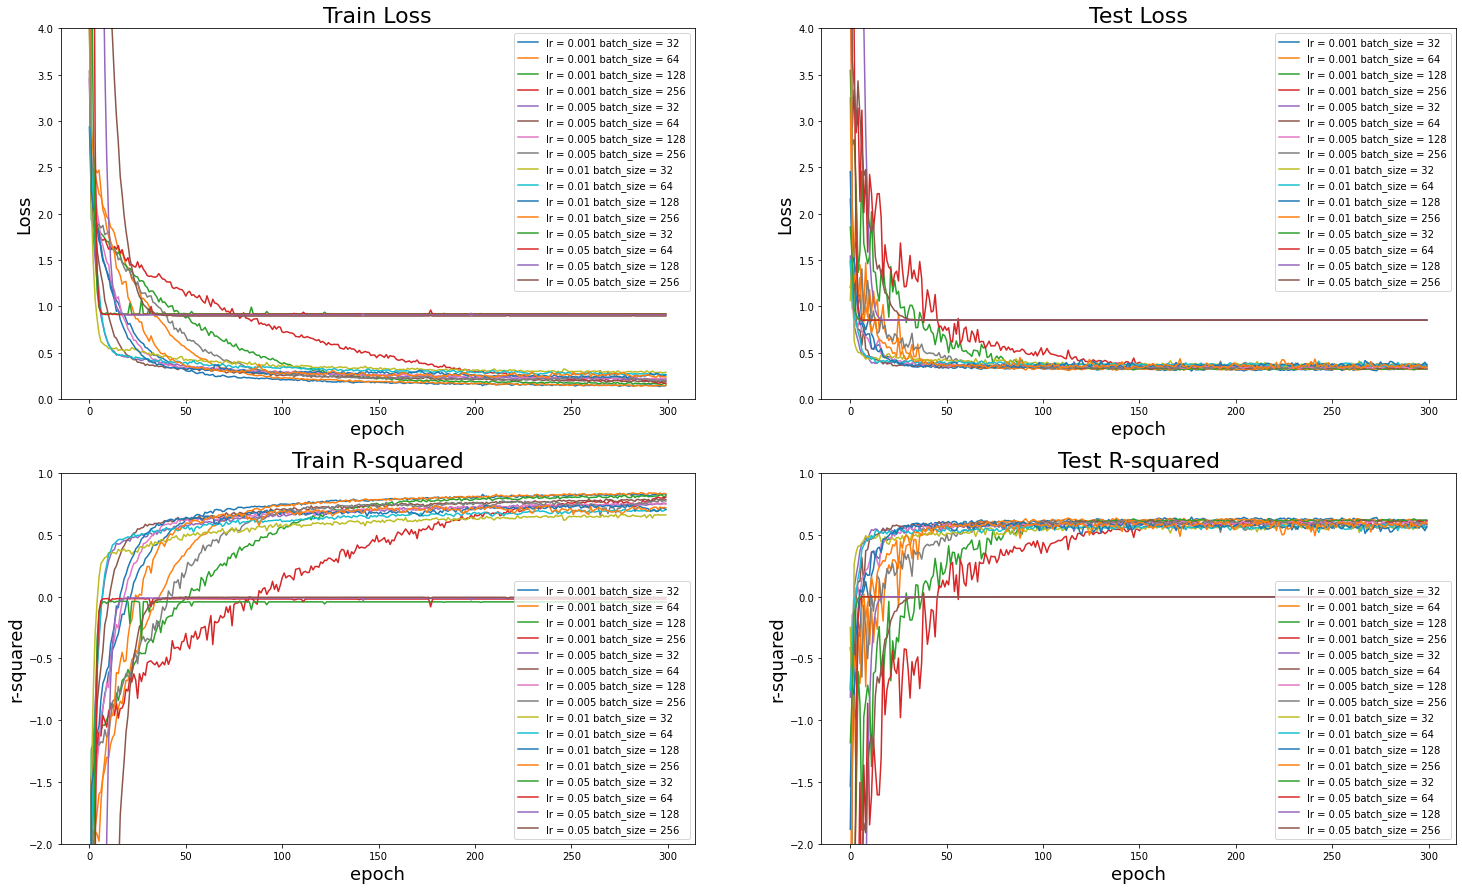

<Figure size 1800x1080 with 0 Axes>

In [12]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 4])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 4])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

In [13]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   

0.8289719292426286
0.8318317870674149
0.8198683126359406
0.8069208575782684
0.754878465635679
0.785866800994048
0.7489686394853791
0.7749960548556079
0.6618342569056
0.7061900788035044
0.7056463130317456
0.718493231502218
-0.041789205897369126
-0.01870692839546693
-0.010979512586853856
-0.004996471769149487
___________________

0.6087515009372094
0.6158608711696453
0.6211363818057724
0.615549921144088
0.5826972234515617
0.5862944606691356
0.6042011150108901
0.5852126286065427
0.5601529345257052
0.5668296070762169
0.5664871143750514
0.5933577894456334
-0.0024772558819137203
-0.00014403040071520046
-0.0018018856245494153
-7.387038638939636e-05
___________________

0.1468394505011933
0.14751414890982148
0.1623962728653924
0.1716729335486889
0.20909739893265547
0.19067295368474263
0.22248872925164337
0.19830464497208594
0.28810579006764
0.26125082940372646
0.26186392835136185
0.2398465593655904
0.9196295978045771
0.9154123258896363
0.9075772204136444
0.8959079921245575
___________________


### 2 best models

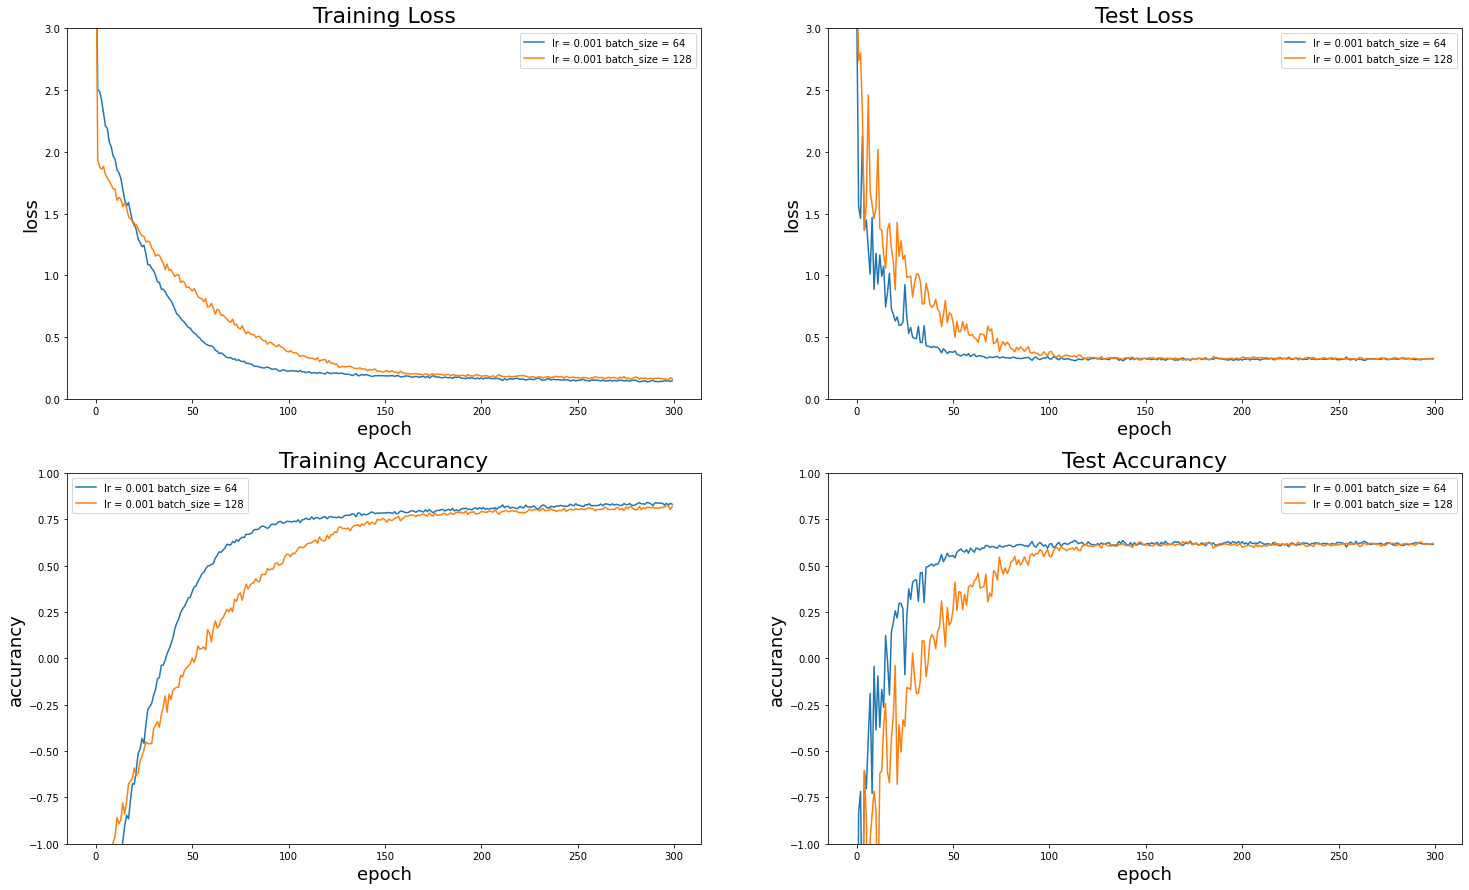

<Figure size 432x288 with 0 Axes>

In [14]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="lr = 0.001 batch_size = 64")
ax1.plot(train_losses_all[2],label="lr = 0.001 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 3])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[1],label="lr = 0.001 batch_size = 64")
ax2.plot(test_losses_all[2],label="lr = 0.001 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 3])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[1],label="lr = 0.001 batch_size = 64")
ax3.plot(train_accs_all[2],label="lr = 0.001 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[1],label="lr = 0.001 batch_size = 64")
ax4.plot(test_accs_all[2],label="lr = 0.001 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])
plt.show()

## 4.2. Training

In [16]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=2127, shuffle=False)

In [17]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/cardio_klek_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 4.743910246820592, Accuracy: -4.496492298515356
Test Avg. loss: 3.202645778656006, Accuracy: -2.576664270167686
################## EPOCH 2 ##################
Train Avg. loss: 2.193759407570113, Accuracy: -1.4846676086243418
Test Avg. loss: 2.959264039993286, Accuracy: -2.304859368399021
################## EPOCH 3 ##################
Train Avg. loss: 2.1249525778329192, Accuracy: -1.4042827192961331
Test Avg. loss: 2.9856724739074707, Accuracy: -2.3343520310835104
################## EPOCH 4 ##################
Train Avg. loss: 2.0662368411448466, Accuracy: -1.3419262585167142
Test Avg. loss: 3.030578374862671, Accuracy: -2.3845020389032103
################## EPOCH 5 ##################
Train Avg. loss: 2.02390145010023, Accuracy: -1.2886136824844785
Test Avg. loss: 2.340062379837036, Accuracy: -1.6133443989929113
################## EPOCH 6 ##################
Train Avg. loss: 1.9838702162699913, Accuracy: -1.2477719202225204
Tes

Train Avg. loss: 0.959604367391387, Accuracy: -0.09040998460678772
Test Avg. loss: 0.7217980623245239, Accuracy: 0.19390734256343567
################## EPOCH 48 ##################
Train Avg. loss: 0.9509135582553807, Accuracy: -0.07526820400160374
Test Avg. loss: 0.6654680967330933, Accuracy: 0.2568157633049797
################## EPOCH 49 ##################
Train Avg. loss: 0.9358378399663897, Accuracy: -0.056136361899858656
Test Avg. loss: 0.5938100218772888, Accuracy: 0.3368423016756964
################## EPOCH 50 ##################
Train Avg. loss: 0.9360941434974102, Accuracy: -0.06186566429914399
Test Avg. loss: 0.7066081762313843, Accuracy: 0.21087112352697512
################## EPOCH 51 ##################
Train Avg. loss: 0.9044321819917479, Accuracy: -0.02593013931893749
Test Avg. loss: 0.6390239000320435, Accuracy: 0.28634819277541335
################## EPOCH 52 ##################
Train Avg. loss: 0.8722103682916555, Accuracy: 0.005479927488309496
Test Avg. loss: 0.56770366430

Train Avg. loss: 0.40656921623358083, Accuracy: 0.5433731358802998
Test Avg. loss: 0.37765979766845703, Accuracy: 0.5782355359475958
################## EPOCH 94 ##################
Train Avg. loss: 0.39445363808034073, Accuracy: 0.5555569894977591
Test Avg. loss: 0.3823537826538086, Accuracy: 0.5729933584892475
################## EPOCH 95 ##################
Train Avg. loss: 0.3824476110401438, Accuracy: 0.5679436144584132
Test Avg. loss: 0.3987693786621094, Accuracy: 0.5546606614435168
################## EPOCH 96 ##################
Train Avg. loss: 0.377460035370357, Accuracy: 0.5761232140215167
Test Avg. loss: 0.3768625557422638, Accuracy: 0.5791258298075685
################## EPOCH 97 ##################
Train Avg. loss: 0.36978900966359607, Accuracy: 0.5829729432582865
Test Avg. loss: 0.4058176279067993, Accuracy: 0.5467892834717791
################## EPOCH 98 ##################
Train Avg. loss: 0.3758538102925713, Accuracy: 0.5743828762691595
Test Avg. loss: 0.3817514181137085, Accur

Train Avg. loss: 0.22028979837004817, Accuracy: 0.7537571100284376
Test Avg. loss: 0.3413423001766205, Accuracy: 0.6187943366022916
################## EPOCH 140 ##################
Train Avg. loss: 0.20897554795243847, Accuracy: 0.7654261850980065
Test Avg. loss: 0.35269999504089355, Accuracy: 0.6061102137943951
################## EPOCH 141 ##################
Train Avg. loss: 0.21779820211787723, Accuracy: 0.7560618170509136
Test Avg. loss: 0.34964242577552795, Accuracy: 0.6095248530007205
################## EPOCH 142 ##################
Train Avg. loss: 0.2228433575425575, Accuracy: 0.7517830525134587
Test Avg. loss: 0.35264748334884644, Accuracy: 0.6061688460289738
################## EPOCH 143 ##################
Train Avg. loss: 0.21695569235442289, Accuracy: 0.7559129965521528
Test Avg. loss: 0.3579596281051636, Accuracy: 0.6002363386595536
################## EPOCH 144 ##################
Train Avg. loss: 0.21563399349575613, Accuracy: 0.7588869558799146
Test Avg. loss: 0.3365426957607

Train Avg. loss: 0.1792915314435959, Accuracy: 0.7986685325234645
Test Avg. loss: 0.32544830441474915, Accuracy: 0.6365445082857174
################## EPOCH 186 ##################
Train Avg. loss: 0.17450246826481464, Accuracy: 0.8048275606919991
Test Avg. loss: 0.32831859588623047, Accuracy: 0.6333389769773581
################## EPOCH 187 ##################
Train Avg. loss: 0.1823621932695161, Accuracy: 0.7955483942923125
Test Avg. loss: 0.3396724462509155, Accuracy: 0.6206591563654404
################## EPOCH 188 ##################
Train Avg. loss: 0.1720852230244608, Accuracy: 0.8075084054399027
Test Avg. loss: 0.33582547307014465, Accuracy: 0.6249554211189343
################## EPOCH 189 ##################
Train Avg. loss: 0.17328191993396674, Accuracy: 0.805396237910036
Test Avg. loss: 0.3349575698375702, Accuracy: 0.6259246513959498
################## EPOCH 190 ##################
Train Avg. loss: 0.17233751892153895, Accuracy: 0.8075749462387524
Test Avg. loss: 0.3304586112499237

Train Avg. loss: 0.16167332977056503, Accuracy: 0.8190161408028501
Test Avg. loss: 0.3285682797431946, Accuracy: 0.6330601352321434
################## EPOCH 232 ##################
Train Avg. loss: 0.1640834131125194, Accuracy: 0.815918857564047
Test Avg. loss: 0.3325439393520355, Accuracy: 0.6286201759728955
################## EPOCH 233 ##################
Train Avg. loss: 0.16386451105128474, Accuracy: 0.8155891617258508
Test Avg. loss: 0.3391847014427185, Accuracy: 0.6212038736490224
################## EPOCH 234 ##################
Train Avg. loss: 0.16154035169686845, Accuracy: 0.8177439529805189
Test Avg. loss: 0.3307674527168274, Accuracy: 0.6306041603470529
################## EPOCH 235 ##################
Train Avg. loss: 0.1644503984655907, Accuracy: 0.8155338008621749
Test Avg. loss: 0.32948464155197144, Accuracy: 0.6320367631986028
################## EPOCH 236 ##################
Train Avg. loss: 0.16423829878444102, Accuracy: 0.8167021589495089
Test Avg. loss: 0.33539727330207825

Train Avg. loss: 0.15163854309427205, Accuracy: 0.8307238280994421
Test Avg. loss: 0.3292446434497833, Accuracy: 0.6323047678631439
################## EPOCH 278 ##################
Train Avg. loss: 0.15253043096901767, Accuracy: 0.8287015966346978
Test Avg. loss: 0.33373329043388367, Accuracy: 0.6272919527618791
################## EPOCH 279 ##################
Train Avg. loss: 0.1588565838425907, Accuracy: 0.8224280140148577
Test Avg. loss: 0.3276354670524597, Accuracy: 0.6341018760160768
################## EPOCH 280 ##################
Train Avg. loss: 0.1542451348322541, Accuracy: 0.8283136793377248
Test Avg. loss: 0.3325897753238678, Accuracy: 0.6285690177773948
################## EPOCH 281 ##################
Train Avg. loss: 0.15160002637265332, Accuracy: 0.8315959874131112
Test Avg. loss: 0.332158625125885, Accuracy: 0.6290504972711496
################## EPOCH 282 ##################
Train Avg. loss: 0.1499858207222241, Accuracy: 0.8322109889988096
Test Avg. loss: 0.32835012674331665,

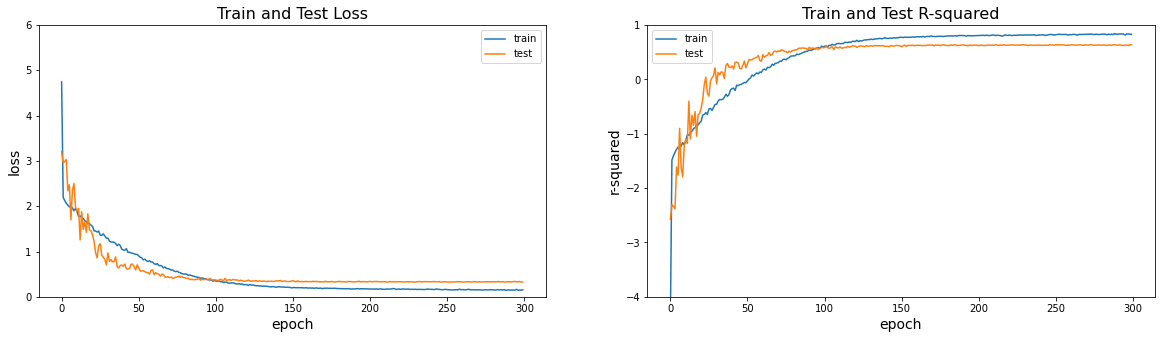

<Figure size 1440x360 with 0 Axes>

In [18]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0, 6])
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.set_ylim([-4, 1])
ax2.legend()
plt.show()

In [19]:
model = FCNN()
model.load_state_dict(torch.load('../../models/cardio_klek_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.3829539
MSE: 0.32233554
RMSE: 0.56774604
R2 Square 0.640020753861607 

